In [1]:
import os
from skimage import measure
from PIL import Image
import numpy as np
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2

In [2]:

# def create_lines(contour, distance=1):
#     res = [contour[0]]
#     poz = 0
#     while poz < len(contour):
#         a = res[-1]#contour[(poz-distance)%len(contour)]
#         b = contour[poz]
#         c = contour[(poz+distance)%len(contour)]
        
#         ab = a-b
#         ac = c-b
#         ab /= np.linalg.norm(ab)
#         ac /= np.linalg.norm(ac)
        
#         if np.abs(np.dot(ab,ac)) <0.95 :
#             res.append(contour[poz])
#             #res.append(contour[(poz+distance)%len(contour)])
#             poz += distance
#         else:
#             poz += 1
#        # print(np.dot(ab,ac))
#        # break
#     return np.array(res)

# def reduce_contour(contour, n=5):
#     n = 5
#     res = contour.copy()
#     for i in range(1,n):
#         res += np.roll(contour, i, axis=0)
#     return res[::n]/n

# def join_close_points(contour, threshold=30):
#     res = [contour[0]]
#     for cur in contour:
#         if np.linalg.norm(res[-1]-cur) < threshold:
#             res[-1] = (res[-1]+cur)/2
#         else:
#             res.append(cur)
#     return np.array(res)

# def create_countur(img):
#     contour = measure.find_contours(img, 0.5)[0]
#     contour = reduce_contour(contour, 10)
#     contour = create_lines(contour,5)
#     contour = cv2.approxPolyDP(contour, 2, True)
#     return contour
# path = "set8"
# def load_image(path):
#     print(path)
#     img = Image.open(path)
#     img.load()
#     return np.asarray( img, dtype="float" )
# images_paths = [os.path.join(path,x) for x in os.listdir(path) if ".png" in x]
# images = [load_image(_) for _ in images_paths]
# images = [resize(_, (1000, 1000)) for _ in images]
# for i,p in zip(images, images_paths):
#     fig, ax = plt.subplots()
#     ax.matshow(i,cmap=plt.cm.gray)
    
#     contour = create_countur(i)
#     print(p)
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
#     ax.scatter(contour[:, 1], contour[:, 0], )
    
#     dis = []
#     for poz in range(len(contour)):
#         dis.append(np.linalg.norm(contour[poz-1]-contour[poz%len(contour)]))
#     dis = np.array(dis)
#     print(dis)
    
#     plt.show()
    


In [3]:
# def is_convex(points_idx, points):
#     negative = False
#     positive = False
#     for poz in range(len(points_idx)):
        
#         a = points[points_idx[(poz-1)%len(points_idx)]]
#         b = points[points_idx[poz]]
#         c = points[points_idx[(poz-2)%len(points_idx)]]
#         if np.cross((a-b), (c-b))>= 0:
#             positive = True
#         else:
#             negative = False
        
#     return not negative^positive

# def next_point_good_side(points_idx, points):
#     for i in range(3):
#         b = points[points_idx[i+1]]
#         c = points[points_idx[i]]
#         poz = points_idx[0]+1
#         poz %= len(points)
#         bad_count = 0
#         while poz != points_idx[1]:
#             a = points[poz]
#             poz = (poz+1)%len(points)
#             if np.cross((a-b),(c-b)) < 0:
#                 bad_count += 1
#         if bad_count > 1:
#             return False
#     return True
    
# def find_base(contour):
#     angles = []
    
#     for poz in range(len(contour)):
#         a = contour[poz-1]
#         b = contour[poz]
#         c = contour[(poz+1)%len(contour)]
#         ab = a-b
#         ac = c-b
#         ab = ab/np.linalg.norm(ab)
#         ac = ac/np.linalg.norm(ac)
#         angles.append(np.dot(ab,ac))
    
#     eps = 0.00
#     while eps < 1.1:
#         options = []
#         for p in range(len(contour)):
#             if np.abs(angles[p]) < eps and np.abs(angles[p-1]) < eps and np.linalg.norm(contour[p]-contour[p-1])> 10:
#                 options.append([(p+1)%len(contour), p,
#                                (p-1)%len(contour), (p-2)%len(contour)])
#         options = [_ for _ in options if is_convex(_, contour)]
#         options = [_ for _ in options if next_point_good_side(_, contour)]
        
#         if len(options) > 0:
#             return options[0]
#         eps += 0.05
    
#     return []
        
# for p in images_paths:
#     image1 = cv2.imread(p)
#     image1 = cv2.resize(image1, (1000,1000))
#     gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
#     #canimg = cv2.Canny(gray, 50, 200)
#     _,canimg = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY)
#     contours,_ = cv2.findContours(canimg, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
#     contour = contours[0]#np.concatenate(contours)
    
#     for c in contours:
#         if c.shape[0] > contour.shape[0]:
#             contour = c
    
    
#     # for c in contours[1:]:
#     #     print(c.shape, contour.shape)
#     #     contour = np.concatenate(contour, c)
#     c = cv2.approxPolyDP(contour, 10, True)
#     c = c.reshape((-1,2))
#     base_idx = find_base(c)
#     top = np.array([c[_] for _ in base_idx])
# #     top = []
# #     poz = (base_a+1)%len(c)
# #     while poz != (base_b-2)%len(c):
# #         top.append(c[poz])
# #         poz = (poz-1)%len(c)
# #     top = np.array(top)
# #     if len(top) > 0:
# #         plt.scatter(top[:,0],top[:,1] )
# #     if len(top) == 0:
# #         d = []
# #         for i in range(len(c)):
# #             d.append(np.linalg.norm(c[i]-c[i-1]))
# #         print(d)
#     plt.imshow(canimg)
#     plt.scatter(top[:,0], top[:,1])
# #         plt.plot(c[:,0], c[:,1])
#     plt.show()
# len(images)

In [4]:
def point_to_line_dist(point, line):
    """Calculate the distance between a point and a line segment.

    To calculate the closest distance to a line segment, we first need to check
    if the point projects onto the line segment.  If it does, then we calculate
    the orthogonal distance from the point to the line.
    If the point does not project to the line segment, we calculate the 
    distance to both endpoints and take the shortest distance.

    :param point: Numpy array of form [x,y], describing the point.
    :type point: numpy.core.multiarray.ndarray
    :param line: list of endpoint arrays of form [P1, P2]
    :type line: list of numpy.core.multiarray.ndarray
    :return: The minimum distance to a point and bool if point lie on line.
    :rtype: (float, bool)
    """
    # unit vector
    unit_line = line[1] - line[0]
    norm_unit_line = unit_line / np.linalg.norm(unit_line)
    # compute the perpendicular distance to the theoretical infinite line
    segment_dist = (
        np.linalg.norm(np.cross(line[1] - line[0], line[0] - point)) /
        np.linalg.norm(unit_line)
    )

    diff = (
        (norm_unit_line[0] * (point[0] - line[0][0])) + 
        (norm_unit_line[1] * (point[1] - line[0][1]))
    )

    x_seg = (norm_unit_line[0] * diff) + line[0][0]
    y_seg = (norm_unit_line[1] * diff) + line[0][1]

    endpoint_dist = min(
        np.linalg.norm(line[0] - point),
        np.linalg.norm(line[1] - point)
    )

    # decide if the intersection point falls on the line segment
    lp1_x = line[0][0]  # line point 1 x
    lp1_y = line[0][1]  # line point 1 y
    lp2_x = line[1][0]  # line point 2 x
    lp2_y = line[1][1]  # line point 2 y
    is_betw_x = lp1_x <= x_seg <= lp2_x or lp2_x <= x_seg <= lp1_x
    is_betw_y = lp1_y <= y_seg <= lp2_y or lp2_y <= y_seg <= lp1_y
    if is_betw_x and is_betw_y:
        return segment_dist

    else:
        # if not, then return the minimum distance to the segment endpoints
        return endpoint_dist


In [12]:
import skimage

def compute_angles(points):
    angles = []
    n = len(points)
    for poz in range(len(points)):
        a = points[poz-1]
        b = points[poz]
        c = points[(poz+1)%n]
        ab = a-b
        ac = c-b
        ab = ab/np.linalg.norm(ab)
        ac = ac/np.linalg.norm(ac)
        angles.append(np.dot(ab,ac)) #cos(a)
    return angles

def next_point_good_side(points_idx, points):
    for i in range(len(points_idx)-1):
        b = points[points_idx[i+1]]
        c = points[points_idx[i]]
        poz = points_idx[0]+1
        poz %= len(points)
        bad_count = 0
        while poz != points_idx[1]:
            a = points[poz]
            poz = (poz+1)%len(points)
            if np.cross((a-b),(c-b)) < 0:
                bad_count += 1
        if bad_count > 1: #random close point
            return False
    return True

def get_lenght(points_idx, points):
    res = 0
    for a,b in zip(points_idx, points_idx[1:]):
        res += np.linalg.norm(points[a]-points[b])
    return res

def find_base_points_idx(contour):
    angles = compute_angles(contour)
    eps = 0.00
    options = []
    while eps < 1.1 and len(options) == 0:
        for p in range(len(contour)):
            if (np.abs(angles[p]) < eps and np.abs(angles[p-1]) < eps): #and 
                #np.linalg.norm(contour[p]-contour[p-1]) > 10):
                
                options.append([(p+1)%len(contour), p,
                               (p-1)%len(contour), (p-2)%len(contour)])
        options = [_ for _ in options if next_point_good_side(_, contour)]
        eps += 0.05
    if len(options) > 0:
        res = options[0]
        res_lenght = get_lenght(res, contour)
        for o in options[1:]:
            lenght = get_lenght(o, contour)
            if lenght > res_lenght:
                res_lenght = lenght
                res = o
        return res
    return [0,1,2,3] # Broken
                
def generate_top_points(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,canimg = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(canimg, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    
    contour = contours[0]
    for c in contours:
        if c.shape[0] > contour.shape[0]:
            contour = c
    contour = cv2.approxPolyDP(contour, 10, True)
    contour = contour.reshape((-1,2))
    
    base = find_base_points_idx(contour)
    n = len(contour)
    poz = base[0]
    res = []
    while poz != base[-2]:
        res.append(contour[poz])
        poz = (poz+1)%n
        
    return np.array(res)
def generate_data(path):
    images_paths = [os.path.join(path,x) for x in os.listdir(path) if ".png" in x]
    points = []
    for p in sorted(images_paths, key=lambda x: int(x.split("/")[1].split(".")[0])): #TODO
        image = cv2.imread(p)
        image = cv2.resize(image, (1000,1000))
        points.append(generate_top_points(image))
    return points


def normalize_data(images_points):
    res = []
    base_vec = np.array([1,0])
    for points in images_points:
        points = points-points[0]
        points = points/np.linalg.norm(points[-1])
        cos = np.dot(points[-1],base_vec)/np.linalg.norm(points[-1])
        sin = np.cross(points[-1],base_vec)/np.linalg.norm(points[-1])
        j = np.matrix([[cos, sin], [-sin, cos]])
        tmp = np.matmul(points, j)
        tmp[:,1] /= np.max(np.abs(tmp[:,1]))
        res.append(tmp)
    
    return res

def get_distance(points_a, points_b, threshold):
    res = 0
    for p in points_a:
        distances_rev = [point_to_line_dist(np.array(p).flatten(), np.array([p1,p2]).reshape((2,2))) for p1,p2 in zip(points_b, points_b[1:])]
        res += np.min(distances_rev)
        if res > threshold:
            break
    return res

def generate_ranking(other_points, points):
    res = []
    for other in other_points:
        rev_other = other.copy()*-1
        rev_other[:,0] += 1
        if len(res) > 0:
            threshold = sorted(res)[5%len(res)]
        else:
            threshold = 1000000
        res.append(get_distance(points, rev_other, threshold)+get_distance(rev_other, points, threshold))
        
  #  print(res)
    return np.argsort(res)
path = "set8"
t = normalize_data(generate_data(path))
correct = [int(line) for line in open(os.path.join(path, "correct.txt"))]
score = 0
p = 0
for current, correct in zip(t, correct):
    
    ranking = generate_ranking(t, current)
    score += 1/(np.where(ranking==correct)[0]+1)
    print(p,ranking, np.where(ranking==correct), correct, score)
    p += 1
    
    
score/len(t)    

# # plt.plot(t[3][:,0], t[3][:,1])
# # plt.show()
# # a = t[5]
# # a *= -1
# # a[:,0] += 1
# # plt.plot(a[:,0], a[:,1])
# # plt.show()

# # a = t[16]
# # a *= -1
# # a[:,0] += 1
# # plt.plot(a[:,0], a[:,1])
# # plt.show()

# a = t[17]
# a *= -1
# a[:,0] += 1
# plt.plot(a[:,0], a[:,1])
# plt.show()
# generate_ranking(t, t[3])


0 [31  5 69 12 77 18 50  2 91 46 89 56 86 30 94 19 32 84 54 29 72  6 83 14
 39 27 95 60 67 45 93 24  9 42  7 13 21 58 92 85 34 82 48 90 51 65 22 68
 66 25 55 57 73 98 28 53 81 61 96 78 20 44  0 41 49 35 40 79  1 80 88 97
 16 38 87 17 59 74 76 52 62 71 37 23 70 15 64 63 99 75 47 26 36 33  8 43
  3 11  4 10] (array([0]),) 31 [1.]
1 [40 93 73 11 81 76 16 28 99 34 48 82 85 58 54 72 60 52 78 49 64 50 62 80
 87 63 98 75 24  1 32 91 77 71 89 84 79 33 92 88 43 21 69 95 86 56 15 94
 44 26 59  5 90 38 35 97 41 83 65 45 47 96 51 42 74 30 36 46 70 68 23  3
 67 22 55 37 39 29 57 53 66 10 61 31  4 19 20 18 17 27  0  8 14 25  2 12
 13  7  9  6] (array([10]),) 48 [1.09090909]
2 [52 62 45 30 77  0 49 19 93  1 15  5 81 64 18  7 54 73 60 78 58 76 86 23
 40 87 82 85 24 32 72  2 99 63 50 28 84 21 94  3 35 56 31 44 22 75 95 42
 69 48 34 16 98 41 12 26 89 11 51 71 27 79 68 17 65 90 46 33 67 91 47 66
 88 96 80 83 20 55 74 53 70 57 97  6 61 39 92 38 43 29 59  4 25 13 36 37
 10 14  8  9] (array([0]),) 52 [2.090

25 [ 8 28 41 93 79 73 76 10 36 26 16 17 82 85 48 44 75 81 47 33  4 59 34 43
 87 72 40 64 35 71 38 23 70 60 54 32 98 78 46 20 22 84 68 15 58  3 80 63
 62 74 49 51 91 37 99 30 88 50  0 52 94 42 86 61 83 97 89 24 45 18 69  7
 19 21 90 92 77 96 66 67 55 57 53 31  5 29 65 95 56 39 11 25 13 14  1 27
  6 12  2  9] (array([0]),) 8 [22.3759231]
26 [60 54 65 90 86 97 56 53 72 39 21 42 25 57 27  6  9 12 94 67 96 89 92 88
 93 95 32 91 69 55 46 83 66 50 82 85  5 29 58 61 74 31 28 77 68 84 78 14
  1 24 98 18 48 34 37 51 59 38 80 70 76 79 45 75 71 99 87 13 81 30 19 43
 64 63  7 73 22 40 62 41 44 47 36 35 52 16 49 17 23 20  2 33 26 15  0  8
  3 10  4 11] (array([2]),) 65 [22.70925643]
27 [44 87 76 64  3 75 35 63 81 40 93 43 62 26 82 85 47 10 48  8 79 28 41 33
 73 58 49 34 54 60 15 45  5 78 99 11 72 18 23 17 50 16 89  0 71 38 84 95
 20 52 98 22 94  4 88 86 30 59 46 77 90 32 70 36 92 80 97 96 91 83 69 19
 65 24  1 42 21 57 68 61 74 51 66 55 67 56 37 53 31 39 14  7  2 13 12 27
 25  6 29  9] (array([0]),)

50 [ 7 30 17 79  0 49 22 93 19 23 77 38 12 73  1 24 32 28 40 81 34 48 85 82
 45 62 52 41 78 26 21 36 76 27 18 54  5 46 72 31 91 58 84 60 66 15 56 35
  4  8 37 87 42 89 71 51 63 20 94 99 33  2 47 29 55  6 98 44 69 75 86 68
 95 90 16 14 70 25 88 83 43 67 13 74 50 64 39 80 10 65 59  3 11 92 53 61
 96 97 57  9] (array([0]),) 7 [41.61320653]
51 [44 20 17 79 41 28 87 35 37 75 85 82 74  8 93 80 22 81 64 68 76 48 73 30
 72 88 47 23 49 54 60 40 62 13 36 34 84  3 58 86 16 10 38  0 18 19 94 46
 14 45 63 42 59 78 98  5 50 70 25  7 26 56 31  6 91 21 77 39 71 43 15 33
 66 32 24  1 51 69  4 65 83 92 96 97 90 52 61  2 99 67 53 89 12 95 55 57
 27 11 29  9] (array([18]),) 64 [41.66583811]
52 [ 2 77 12 18 69  5 31 45 89 56 30 86 19 60 95 93 91 29 32 54 72 85 82 58
 50 94 39 67 90  9 81 73 27 21 40 42  7 66 24 84 49 46 76 96 78 55 34 48
 44 92 65  1  6 83 41 62 57 22 28 53  0 52 13 87 14 25 88 64 79 70 97 75
 98 51 71 15 20 99 80 59 35 38 17 63 61 23 74 37 16 68 47 33 36 43 26  3
 11 10  8  4] (array([0])

75 [96 90 27 29 12 66 56 25 65 72 53 86 60 51 67  6 54 92 94 93 91 57 82 85
 84 13 55 97 95 88 69 21 58 39 89 32 61 42 46  5 77 81  7 14  9 31 59 70
 83 37 73 18 48 34 80 74 79 76 28 71 98 68 99 75 24  1 50 78 40 19 87 38
 16 30 41 64 45 17 22 63 62 49 20  2 52  0 23 36 43 35 44 33 15 47 26  8
  3 10  4 11] (array([0]),) 96 [62.25060002]
76 [56 27 29 42 21 90 54 65 39 57 66 25 60 72 86 12 95 92 94 67 91 89 24  1
 32  6 77 53 69 55 93 96  9 85 82 31  5 50 58 78 68 13 88 18 97 59 45 83
 51 19 84 46 98 80 61 74 40 28  7 99 70 79 87 63 64 38 48 34 30 81 73 52
 22 44 37 49 62 71 75 14  2 20 41 43 47 76 35 16 36 17 15 23 33 26  0  8
  4 10  3 11] (array([0]),) 56 [63.25060002]
77 [45 19 52 62 77 15 78 76 18 93 30 64  0 81 58  2  3 49 73 23 86 32  1 99
 50 40 11 87 48 82 85 44 94  5 35 22 84 28 89 12 54 79 41 17 24 88 34 60
  7 56 21 72 75 90 63 26 27 91 68 31 42 80 69 16 20 47 98 38 70 65 46 59
 74 71 33  6 97 96 83 51  8 25 13 95 92 66 29 37 10 67 39 36  4 14 43 53
 61 57 55  9] (array([0])

array([0.83824535])

set8/0.png
set8/1.png
set8/2.png
set8/3.png
set8/4.png
set8/5.png
set8/6.png
set8/7.png
set8/8.png
set8/9.png
set8/10.png
set8/11.png
set8/12.png
set8/13.png
set8/14.png
set8/15.png
set8/16.png
set8/17.png
set8/18.png
set8/19.png
set8/20.png
set8/21.png
set8/22.png
set8/23.png
set8/24.png
set8/25.png
set8/26.png
set8/27.png
set8/28.png
set8/29.png
set8/30.png
set8/31.png
set8/32.png
set8/33.png
set8/34.png
set8/35.png
set8/36.png
set8/37.png
set8/38.png
set8/39.png
set8/40.png
set8/41.png
set8/42.png
set8/43.png
set8/44.png
set8/45.png
set8/46.png
set8/47.png
set8/48.png
set8/49.png
set8/50.png
set8/51.png
set8/52.png
set8/53.png
set8/54.png
set8/55.png
set8/56.png
set8/57.png
set8/58.png
set8/59.png
set8/60.png
set8/61.png
set8/62.png
set8/63.png
set8/64.png
set8/65.png
set8/66.png
set8/67.png
set8/68.png
set8/69.png
set8/70.png
set8/71.png
set8/72.png
set8/73.png
set8/74.png
set8/75.png
set8/76.png
set8/77.png
set8/78.png
set8/79.png
set8/80.png
set8/81.png
set8/82.png
set8/83.png
se

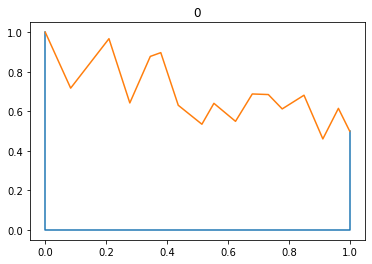

(2, 2)
[[-614.  132.    0.]
 [-122.  797.    1.]]


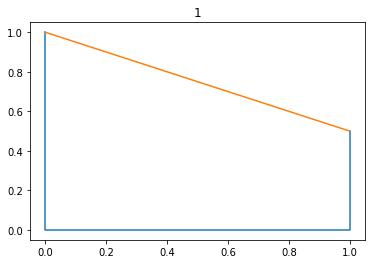

(23, 2)
[[-4.01000000e+02 -7.50000000e+01  0.00000000e+00]
 [-2.70000000e+02 -2.80000000e+01  3.92313699e-02]
 [-2.10000000e+02  3.10000000e+01  1.04029891e-01]
 [-2.97000000e+02  5.10000000e+01  1.41976726e-01]
 [-2.78000000e+02  7.60000000e+01  1.70390128e-01]
 [-2.84000000e+02  9.90000000e+01  2.00026293e-01]
 [-4.37000000e+02  1.07000000e+02  2.32803311e-01]
 [-4.50000000e+02  1.16000000e+02  2.45986027e-01]
 [-4.40000000e+02  1.39000000e+02  2.73240021e-01]
 [-5.47000000e+02  1.86000000e+02  3.47906177e-01]
 [-5.44000000e+02  2.31000000e+02  4.03695532e-01]
 [-4.26000000e+02  3.11000000e+02  4.86102158e-01]
 [-3.62000000e+02  3.35000000e+02  5.06566016e-01]
 [-4.52000000e+02  3.69000000e+02  5.62455156e-01]
 [-4.15000000e+02  3.87000000e+02  5.79440792e-01]
 [-5.98000000e+02  4.16000000e+02  6.42927852e-01]
 [-5.88000000e+02  4.48000000e+02  6.81429049e-01]
 [-7.19000000e+02  4.83000000e+02  7.44672190e-01]
 [-7.05000000e+02  5.04000000e+02  7.68831263e-01]
 [-7.35000000e+02  5.17

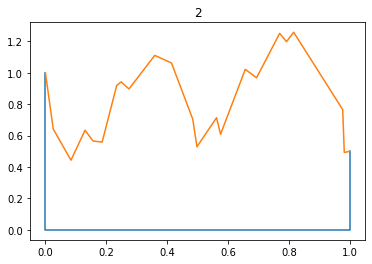

(16, 2)
[[ 1.99000000e+02  2.49000000e+02  0.00000000e+00]
 [ 1.46000000e+02  7.50000000e+01  1.30669456e-01]
 [ 1.86000000e+02  9.40000000e+01  1.47061928e-01]
 [ 2.12000000e+02  3.00000000e+01  2.35895679e-01]
 [ 2.49000000e+02  2.40000000e+01  2.75198356e-01]
 [ 3.12000000e+02  6.30000000e+01  2.91724144e-01]
 [ 3.88000000e+02  7.80000000e+01  3.44475202e-01]
 [ 3.96000000e+02  3.50000000e+01  3.95674595e-01]
 [ 4.48000000e+02 -5.00000000e+00  4.83234425e-01]
 [ 4.28000000e+02 -6.10000000e+01  5.22651903e-01]
 [ 4.32000000e+02 -1.60000000e+02  6.27607788e-01]
 [ 5.02000000e+02 -1.27000000e+02  6.56550600e-01]
 [ 4.73000000e+02 -2.14000000e+02  7.19644858e-01]
 [ 5.26000000e+02 -2.71000000e+02  8.25508041e-01]
 [ 5.33000000e+02 -3.04000000e+02  8.65571737e-01]
 [ 6.83000000e+02 -3.04000000e+02  1.00000000e+00]]


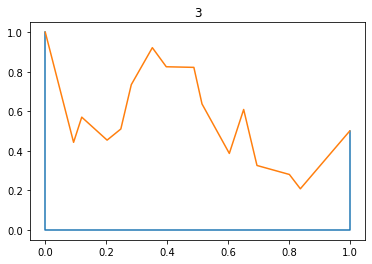

(22, 2)
[[ 2.43000000e+02 -6.80000000e+01  0.00000000e+00]
 [ 2.77000000e+02 -1.12000000e+02  4.77403074e-02]
 [ 2.78000000e+02 -1.37000000e+02  8.09589355e-02]
 [ 2.56000000e+02 -1.53000000e+02  1.09749943e-01]
 [ 1.16000000e+02 -1.70000000e+02  1.79135123e-01]
 [ 1.77000000e+02 -2.19000000e+02  2.24604267e-01]
 [ 1.63000000e+02 -2.63000000e+02  2.88311539e-01]
 [ 1.23000000e+02 -2.60000000e+02  2.97591191e-01]
 [ 1.53000000e+02 -3.07000000e+02  3.50688231e-01]
 [ 9.80000000e+01 -3.13000000e+02  3.77036017e-01]
 [ 1.25000000e+02 -3.45000000e+02  4.11000229e-01]
 [ 4.20000000e+01 -3.77000000e+02  4.81555403e-01]
 [ 7.60000000e+01 -4.15000000e+02  5.21243404e-01]
 [ 6.60000000e+01 -4.34000000e+02  5.50068823e-01]
 [-1.70000000e+01 -4.51000000e+02  6.00493232e-01]
 [ 1.10000000e+02 -5.89000000e+02  7.43450333e-01]
 [ 1.10000000e+02 -6.36000000e+02  8.06526726e-01]
 [ 8.30000000e+01 -6.34000000e+02  8.12824042e-01]
 [ 8.20000000e+01 -6.51000000e+02  8.35971553e-01]
 [-4.80000000e+01 -6.26

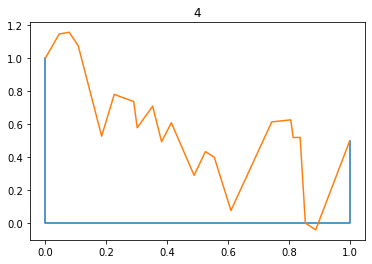

(17, 2)
[[1.18000000e+02 4.32000000e+02 0.00000000e+00]
 [1.20000000e+02 2.74000000e+02 1.18487395e-01]
 [1.45000000e+02 2.19000000e+02 1.87815126e-01]
 [2.49000000e+02 3.44000000e+02 2.16071429e-01]
 [2.95000000e+02 4.27000000e+02 2.08193277e-01]
 [3.06000000e+02 4.24000000e+02 2.23109244e-01]
 [3.05000000e+02 3.14000000e+02 3.02836134e-01]
 [3.17000000e+02 3.16000000e+02 3.15231092e-01]
 [3.24000000e+02 2.80000000e+02 3.49789916e-01]
 [3.97000000e+02 3.46000000e+02 3.85609244e-01]
 [4.69000000e+02 4.81000000e+02 3.69537815e-01]
 [4.93000000e+02 2.67000000e+02 5.54621849e-01]
 [4.93000000e+02 1.03000000e+02 6.75210084e-01]
 [5.98000000e+02 2.27000000e+02 7.05357143e-01]
 [6.54000000e+02 2.46000000e+02 7.56092437e-01]
 [7.28000000e+02 1.81000000e+02 8.89390756e-01]
 [7.34000000e+02 4.00000000e+01 1.00000000e+00]]


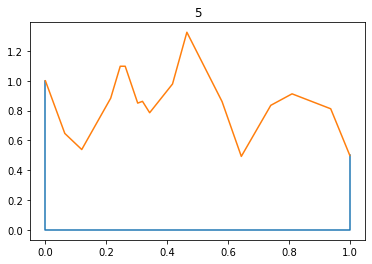

(17, 2)
[[-2.58000000e+02 -3.00000000e+01  0.00000000e+00]
 [-5.73000000e+02 -1.80000000e+01  1.94486740e-01]
 [-4.47000000e+02  3.60000000e+01  1.80989180e-01]
 [-5.70000000e+02  8.30000000e+01  3.03201814e-01]
 [-5.55000000e+02  1.21000000e+02  3.36117962e-01]
 [-3.51000000e+02  1.91000000e+02  2.95206824e-01]
 [-3.16000000e+02  2.36000000e+02  3.24262162e-01]
 [-3.45000000e+02  2.60000000e+02  3.67202975e-01]
 [-5.42000000e+02  3.01000000e+02  5.25461029e-01]
 [-5.98000000e+02  3.44000000e+02  6.04723688e-01]
 [-6.37000000e+02  4.09000000e+02  6.98255152e-01]
 [-6.33000000e+02  4.48000000e+02  7.38598166e-01]
 [-5.43000000e+02  4.78000000e+02  7.19584291e-01]
 [-7.18000000e+02  5.27000000e+02  8.73923502e-01]
 [-4.87000000e+02  6.09000000e+02  8.30588667e-01]
 [-5.95000000e+02  6.46000000e+02  9.33229992e-01]
 [-6.35000000e+02  6.86000000e+02  1.00000000e+00]]


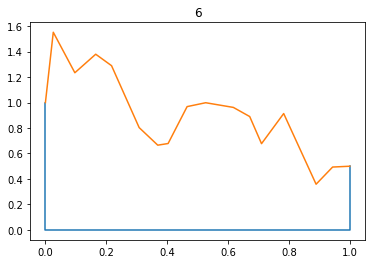

(17, 2)
[[ 1.45000000e+02 -3.36000000e+02  0.00000000e+00]
 [ 1.22000000e+02 -3.21000000e+02  2.18942010e-02]
 [ 1.37000000e+02 -4.44000000e+02  9.12930669e-02]
 [ 9.80000000e+01 -4.35000000e+02  1.40564778e-01]
 [ 8.90000000e+01 -4.59000000e+02  1.71208332e-01]
 [ 2.80000000e+01 -3.94000000e+02  2.10637672e-01]
 [ 1.00000000e+01 -4.54000000e+02  2.80793844e-01]
 [-9.00000000e+00 -4.55000000e+02  3.08777719e-01]
 [-1.53000000e+02 -3.16000000e+02  4.12531197e-01]
 [-1.47000000e+02 -4.91000000e+02  5.33268099e-01]
 [-1.84000000e+02 -4.52000000e+02  5.57499278e-01]
 [-2.77000000e+02 -4.08000000e+02  6.58335437e-01]
 [-2.64000000e+02 -6.53000000e+02  8.20770994e-01]
 [-2.88000000e+02 -6.31000000e+02  8.38925511e-01]
 [-3.02000000e+02 -6.37000000e+02  8.63435149e-01]
 [-3.09000000e+02 -7.50000000e+02  9.56989723e-01]
 [-4.06000000e+02 -6.20000000e+02  1.00000000e+00]]


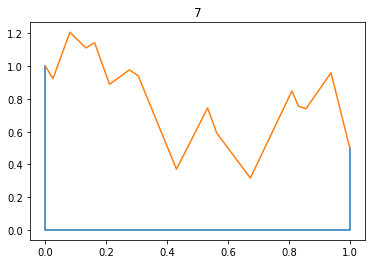

(14, 2)
[[ 4.88000000e+02  2.05000000e+02  0.00000000e+00]
 [ 5.68000000e+02  1.61000000e+02  8.44646587e-02]
 [ 4.46000000e+02  3.80000000e+01  2.51015554e-01]
 [ 4.29000000e+02 -9.00000000e+00  3.20618144e-01]
 [ 4.70000000e+02 -2.10000000e+01  3.47514684e-01]
 [ 4.74000000e+02 -4.10000000e+01  3.79393883e-01]
 [ 4.25000000e+02 -8.70000000e+01  4.41002128e-01]
 [ 5.52000000e+02 -9.50000000e+01  4.78993061e-01]
 [ 3.71000000e+02 -2.67000000e+02  7.09800620e-01]
 [ 3.27000000e+02 -3.28000000e+02  7.95720804e-01]
 [ 3.40000000e+02 -3.51000000e+02  8.34072550e-01]
 [ 4.70000000e+02 -3.43000000e+02  8.47807998e-01]
 [ 5.11000000e+02 -4.22000000e+02  9.78802836e-01]
 [ 5.70000000e+02 -4.28000000e+02  1.00000000e+00]]


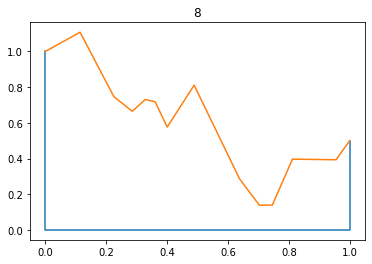

(17, 2)
[[2.20000000e+01 4.02000000e+02 0.00000000e+00]
 [4.20000000e+01 3.31000000e+02 5.03014353e-02]
 [6.50000000e+01 3.19000000e+02 8.11423148e-02]
 [1.41000000e+02 4.08000000e+02 1.33168305e-01]
 [2.50000000e+02 6.07000000e+02 1.80117565e-01]
 [2.72000000e+02 6.07000000e+02 2.05167008e-01]
 [3.22000000e+02 5.68000000e+02 2.77219243e-01]
 [3.36000000e+02 5.15000000e+02 3.13709774e-01]
 [4.07000000e+02 4.54000000e+02 4.18203020e-01]
 [4.93000000e+02 4.42000000e+02 5.20776397e-01]
 [5.11000000e+02 3.92000000e+02 5.60658166e-01]
 [5.64000000e+02 4.81000000e+02 5.86496102e-01]
 [6.40000000e+02 4.52000000e+02 6.84274870e-01]
 [6.76000000e+02 5.38000000e+02 6.91919623e-01]
 [7.39000000e+02 3.65000000e+02 8.30730346e-01]
 [7.54000000e+02 3.83000000e+02 8.40830275e-01]
 [8.09000000e+02 1.34000000e+02 1.00000000e+00]]


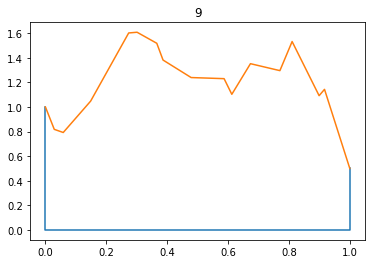

(13, 2)
[[ 2.30000000e+02  3.01000000e+02  0.00000000e+00]
 [ 1.90000000e+02  1.77000000e+02  7.29258631e-02]
 [ 2.81000000e+02  2.23000000e+02  1.25608432e-01]
 [ 2.88000000e+02  1.76000000e+02  1.76451056e-01]
 [ 3.32000000e+02  1.89000000e+02  2.10480261e-01]
 [ 4.43000000e+02  4.00000000e+00  4.97968639e-01]
 [ 4.72000000e+02 -7.70000000e+01  6.03322057e-01]
 [ 4.51000000e+02 -1.86000000e+02  6.82252154e-01]
 [ 4.98000000e+02 -1.77000000e+02  7.23125483e-01]
 [ 5.35000000e+02 -2.44000000e+02  8.23892713e-01]
 [ 6.24000000e+02 -2.21000000e+02  8.95775550e-01]
 [ 7.17000000e+02 -1.63000000e+02  9.39442001e-01]
 [ 7.66000000e+02 -1.73000000e+02  1.00000000e+00]]


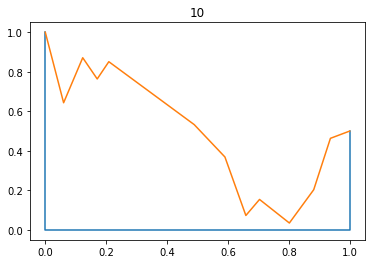

(13, 2)
[[ 7.30000000e+01  6.64000000e+02  0.00000000e+00]
 [ 8.80000000e+01  5.13000000e+02 -2.38850013e-02]
 [ 1.08000000e+02  4.93000000e+02 -1.45856167e-03]
 [ 1.60000000e+02  5.80000000e+02  9.84529129e-02]
 [ 2.16000000e+02  4.15000000e+02  1.28623219e-01]
 [ 2.64000000e+02  4.78000000e+02  2.15668999e-01]
 [ 3.90000000e+02  5.12000000e+02  4.04843605e-01]
 [ 4.34000000e+02  6.05000000e+02  4.95185903e-01]
 [ 4.56000000e+02  5.87000000e+02  5.21052188e-01]
 [ 4.92000000e+02  6.09000000e+02  5.78779192e-01]
 [ 5.73000000e+02  7.02000000e+02  7.21684512e-01]
 [ 6.00000000e+02  7.68000000e+02  7.79795127e-01]
 [ 7.47000000e+02  8.06000000e+02  1.00000000e+00]]


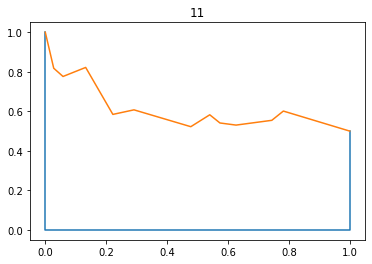

(12, 2)
[[-2.98000000e+02  1.28000000e+02  0.00000000e+00]
 [-4.10000000e+02  2.16000000e+02  7.34720118e-03]
 [-1.65000000e+02  1.90000000e+02  1.90062910e-01]
 [-3.11000000e+02  3.15000000e+02  2.11920834e-01]
 [-5.00000000e+01  4.52000000e+02  6.03205217e-01]
 [-1.21000000e+02  5.35000000e+02  6.40354502e-01]
 [-8.00000000e+00  5.28000000e+02  7.30587317e-01]
 [-1.51000000e+02  6.44000000e+02  7.44317399e-01]
 [-6.00000000e+00  6.48000000e+02  8.75602700e-01]
 [-3.80000000e+01  6.77000000e+02  8.82307021e-01]
 [-2.30000000e+01  6.84000000e+02  9.03751665e-01]
 [ 1.01000000e+02  6.74000000e+02  1.00000000e+00]]


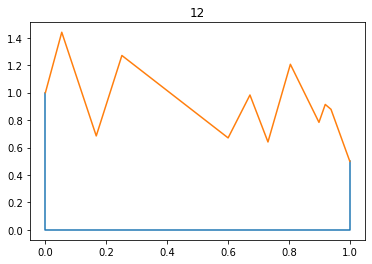

(15, 2)
[[-3.35000000e+02 -7.20000000e+01  0.00000000e+00]
 [-5.24000000e+02 -3.00000000e+01  2.39878815e-01]
 [-5.53000000e+02 -3.00000000e+00  3.04824955e-01]
 [-4.93000000e+02  4.10000000e+01  3.07158887e-01]
 [-5.06000000e+02  4.90000000e+01  3.30655296e-01]
 [-4.88000000e+02  7.60000000e+01  3.50246858e-01]
 [-6.34000000e+02  1.17000000e+02  5.47262118e-01]
 [-5.25000000e+02  1.92000000e+02  5.44748654e-01]
 [-5.25000000e+02  2.27000000e+02  5.92661580e-01]
 [-5.51000000e+02  2.77000000e+02  6.86198384e-01]
 [-5.43000000e+02  3.09000000e+02  7.22284560e-01]
 [-4.98000000e+02  3.40000000e+02  7.21297127e-01]
 [-5.39000000e+02  3.63000000e+02  7.92347397e-01]
 [-7.27000000e+02  3.77000000e+02  9.92930880e-01]
 [-6.79000000e+02  4.16000000e+02  1.00000000e+00]]


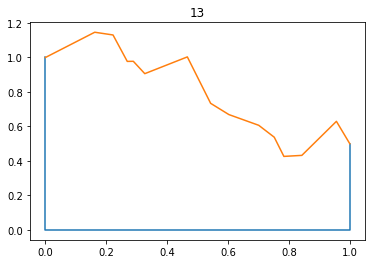

(20, 2)
[[-2.30000000e+02  4.70000000e+01  0.00000000e+00]
 [-2.16000000e+02  6.60000000e+01  3.03461356e-02]
 [-3.26000000e+02  1.27000000e+02  9.10384068e-02]
 [-2.87000000e+02  1.46000000e+02  1.27311522e-01]
 [-3.01000000e+02  1.68000000e+02  1.55286866e-01]
 [-1.87000000e+02  1.74000000e+02  1.90848743e-01]
 [-2.03000000e+02  2.05000000e+02  2.31152205e-01]
 [-1.56000000e+02  2.39000000e+02  2.90659080e-01]
 [-2.31000000e+02  2.81000000e+02  3.32622096e-01]
 [-3.02000000e+02  3.60000000e+02  4.28165007e-01]
 [-2.95000000e+02  3.81000000e+02  4.59696539e-01]
 [-2.13000000e+02  3.83000000e+02  4.81981982e-01]
 [-2.32000000e+02  4.02000000e+02  5.04504505e-01]
 [-1.70000000e+02  4.77000000e+02  6.25889047e-01]
 [-7.80000000e+01  4.88000000e+02  6.63347558e-01]
 [-2.19000000e+02  5.76000000e+02  7.55097202e-01]
 [-5.30000000e+01  6.15000000e+02  8.49928876e-01]
 [-1.35000000e+02  6.90000000e+02  9.37174016e-01]
 [-4.40000000e+01  6.95000000e+02  9.65860597e-01]
 [-1.16000000e+02  7.31

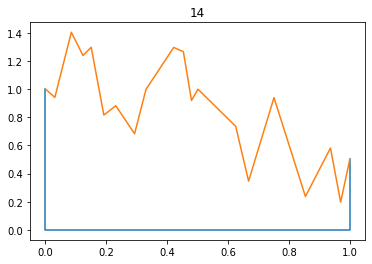

(14, 2)
[[ 4.56000000e+02 -7.60000000e+01  0.00000000e+00]
 [ 3.97000000e+02 -1.17000000e+02  8.24662387e-02]
 [ 1.71000000e+02 -1.93000000e+02  2.94095868e-01]
 [ 2.79000000e+02 -2.52000000e+02  3.15574115e-01]
 [ 2.35000000e+02 -2.68000000e+02  3.58324491e-01]
 [ 3.31000000e+02 -3.58000000e+02  4.25725039e-01]
 [ 2.97000000e+02 -3.65000000e+02  4.51860023e-01]
 [ 2.93000000e+02 -3.93000000e+02  4.89892590e-01]
 [ 3.38000000e+02 -4.81000000e+02  5.80416511e-01]
 [ 2.91000000e+02 -5.16000000e+02  6.49118655e-01]
 [ 3.13000000e+02 -5.66000000e+02  7.02350507e-01]
 [ 2.32000000e+02 -5.84000000e+02  7.66315757e-01]
 [ 2.05000000e+02 -6.29000000e+02  8.37804310e-01]
 [ 1.92000000e+02 -7.50000000e+02  1.00000000e+00]]


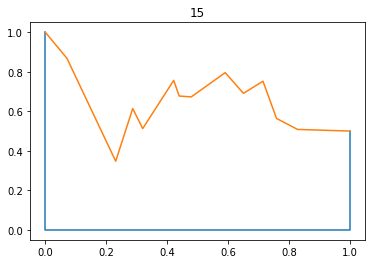

(5, 2)
[[ 2.50000000e+02  4.53000000e+02  0.00000000e+00]
 [ 4.36000000e+02  2.32000000e+02  4.49847015e-01]
 [ 5.03000000e+02  9.80000000e+01  6.72189433e-01]
 [ 5.41000000e+02 -1.02000000e+02  9.35763350e-01]
 [ 7.01000000e+02 -1.00000000e+00  1.00000000e+00]]


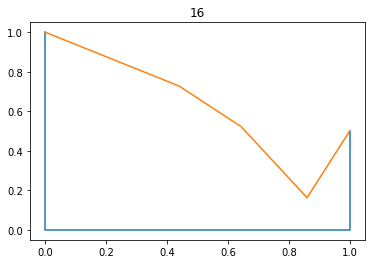

(15, 2)
[[-1.90000000e+01  3.15000000e+02  0.00000000e+00]
 [ 2.40000000e+01  5.10000000e+02  1.63955591e-01]
 [ 1.00000000e+02  3.27000000e+02  1.18144973e-01]
 [ 1.30000000e+02  3.30000000e+02  1.47913386e-01]
 [ 1.55000000e+02  4.67000000e+02  2.58264041e-01]
 [ 2.14000000e+02  4.21000000e+02  2.83799552e-01]
 [ 2.44000000e+02  5.80000000e+02  4.12785873e-01]
 [ 2.59000000e+02  5.91000000e+02  4.33712196e-01]
 [ 2.94000000e+02  5.10000000e+02  4.14698977e-01]
 [ 3.43000000e+02  5.44000000e+02  4.81828675e-01]
 [ 4.47000000e+02  7.63000000e+02  7.17697990e-01]
 [ 6.07000000e+02  4.36000000e+02  6.58310665e-01]
 [ 6.76000000e+02  3.94000000e+02  6.95677017e-01]
 [ 7.03000000e+02  5.28000000e+02  8.05976995e-01]
 [ 7.14000000e+02  8.17000000e+02  1.00000000e+00]]


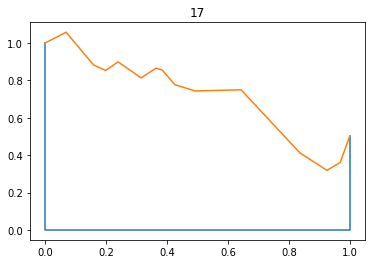

(12, 2)
[[ 2.87000000e+02  2.58000000e+02  0.00000000e+00]
 [ 1.97000000e+02  7.20000000e+01  2.00693778e-01]
 [ 2.77000000e+02  1.02000000e+02  1.96597535e-01]
 [ 2.69000000e+02  6.00000000e+01  2.47235958e-01]
 [ 3.14000000e+02  4.20000000e+01  2.89847959e-01]
 [ 3.05000000e+02 -2.00000000e+01  3.65812975e-01]
 [ 4.38000000e+02  3.10000000e+01  3.57554063e-01]
 [ 4.74000000e+02  2.20000000e+01  3.84688907e-01]
 [ 4.66000000e+02 -1.35000000e+02  5.83437892e-01]
 [ 5.98000000e+02 -9.20000000e+01  5.85050557e-01]
 [ 4.88000000e+02 -3.33000000e+02  8.47944498e-01]
 [ 5.21000000e+02 -4.40000000e+02  1.00000000e+00]]


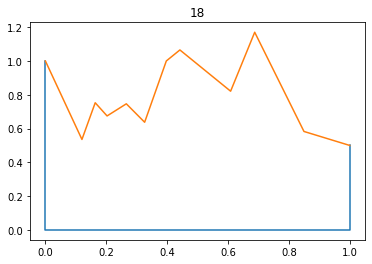

(14, 2)
[[4.20000000e+01 6.25000000e+02 0.00000000e+00]
 [1.19000000e+02 5.59000000e+02 1.08884021e-01]
 [1.87000000e+02 2.06000000e+02 4.08222273e-01]
 [2.61000000e+02 3.76000000e+02 3.51934517e-01]
 [3.66000000e+02 1.83000000e+02 5.71422642e-01]
 [4.08000000e+02 2.07000000e+02 5.89448928e-01]
 [4.75000000e+02 3.88000000e+02 5.19815541e-01]
 [5.20000000e+02 3.05000000e+02 6.14078856e-01]
 [5.70000000e+02 3.29000000e+02 6.38690339e-01]
 [6.02000000e+02 2.66000000e+02 7.08464376e-01]
 [6.16000000e+02 2.73000000e+02 7.15162555e-01]
 [6.46000000e+02 3.82000000e+02 6.64710629e-01]
 [7.18000000e+02 1.15000000e+02 9.08051649e-01]
 [7.56000000e+02 2.70000000e+01 1.00000000e+00]]


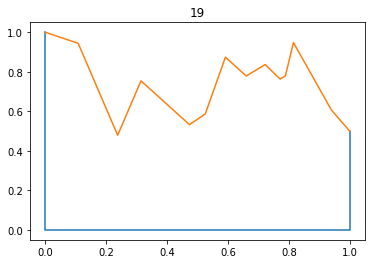

(15, 2)
[[ 1.89000000e+02  2.71000000e+02  0.00000000e+00]
 [ 1.77000000e+02  2.11000000e+02 -1.75115428e-02]
 [ 3.76000000e+02  3.72000000e+02  3.17779479e-01]
 [ 4.14000000e+02  3.87000000e+02  3.82652329e-01]
 [ 3.99000000e+02  3.33000000e+02  3.59632545e-01]
 [ 4.14000000e+02  3.02000000e+02  3.87227578e-01]
 [ 4.66000000e+02  2.92000000e+02  4.77644076e-01]
 [ 4.86000000e+02  2.71000000e+02  5.13342982e-01]
 [ 4.39000000e+02  1.30000000e+02  4.39696419e-01]
 [ 5.82000000e+02  2.27000000e+02  6.81640391e-01]
 [ 5.84000000e+02  1.98000000e+02  6.86658214e-01]
 [ 5.98000000e+02  1.97000000e+02  7.10910026e-01]
 [ 5.75000000e+02  1.29000000e+02  6.74816392e-01]
 [ 6.16000000e+02  1.38000000e+02  7.45197483e-01]
 [ 7.67000000e+02  2.53000000e+02  1.00000000e+00]]


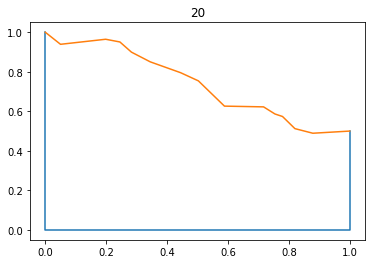

(4, 2)
[[ 3.56000000e+02 -1.34000000e+02  0.00000000e+00]
 [ 4.66000000e+02 -2.72000000e+02  2.65765865e-01]
 [ 5.59000000e+02 -4.79000000e+02  6.35591919e-01]
 [ 5.02000000e+02 -7.20000000e+02  1.00000000e+00]]


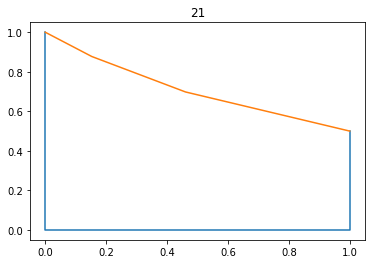

(17, 2)
[[ 1.68000000e+02  3.56000000e+02  0.00000000e+00]
 [ 2.42000000e+02  3.18000000e+02  1.11582454e-01]
 [ 2.31000000e+02  2.23000000e+02  1.74830915e-01]
 [ 2.86000000e+02  2.76000000e+02  1.93321248e-01]
 [ 2.92000000e+02  2.26000000e+02  2.39584809e-01]
 [ 4.18000000e+02  3.11000000e+02  3.10831577e-01]
 [ 3.92000000e+02  1.16000000e+02  4.36892328e-01]
 [ 4.17000000e+02  2.10000000e+01  5.39760566e-01]
 [ 4.74000000e+02  8.10000000e+01  5.54899561e-01]
 [ 5.00000000e+02 -1.30000000e+01  6.58075143e-01]
 [ 6.16000000e+02  1.10000000e+02  6.88174616e-01]
 [ 6.16000000e+02  5.90000000e+01  7.28628086e-01]
 [ 6.45000000e+02  7.20000000e+01  7.50232348e-01]
 [ 6.58000000e+02 -1.20000000e+01  8.31168736e-01]
 [ 6.79000000e+02 -2.30000000e+01  8.63005530e-01]
 [ 6.67000000e+02 -1.18000000e+02  9.25153442e-01]
 [ 7.66000000e+02 -7.50000000e+01  1.00000000e+00]]


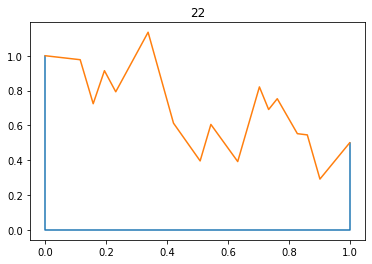

(15, 2)
[[-2.44000000e+02 -1.51000000e+02  0.00000000e+00]
 [-2.68000000e+02 -1.21000000e+02  5.34316116e-02]
 [-3.68000000e+02 -1.42000000e+02  1.48349442e-01]
 [-3.84000000e+02 -1.05000000e+02  1.98841311e-01]
 [-3.10000000e+02  4.30000000e+01  2.44471850e-01]
 [-3.18000000e+02  6.30000000e+01  2.71029914e-01]
 [-3.79000000e+02  8.40000000e+01  3.58505177e-01]
 [-6.00000000e+02  6.00000000e+01  5.87876789e-01]
 [-5.44000000e+02  1.65000000e+02  6.16284739e-01]
 [-5.53000000e+02  1.98000000e+02  6.55347463e-01]
 [-6.24000000e+02  1.81000000e+02  7.20910890e-01]
 [-6.63000000e+02  1.88000000e+02  7.71216336e-01]
 [-6.74000000e+02  2.33000000e+02  8.23041845e-01]
 [-6.59000000e+02  2.74000000e+02  8.41913557e-01]
 [-7.97000000e+02  2.76000000e+02  1.00000000e+00]]


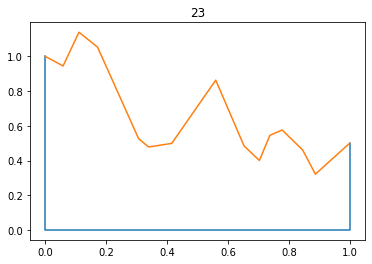

(2, 2)
[[ 140. -146.    0.]
 [-287. -811.    1.]]


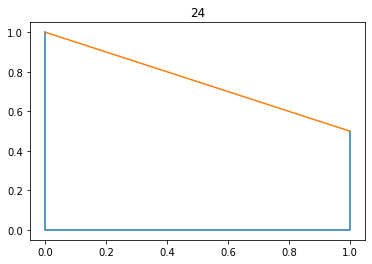

(13, 2)
[[ 1.99000000e+02  2.99000000e+02  0.00000000e+00]
 [ 2.50000000e+02  3.32000000e+02  4.25368314e-02]
 [ 3.22000000e+02  3.15000000e+02  1.69737233e-01]
 [ 4.09000000e+02  3.86000000e+02  2.26770830e-01]
 [ 4.28000000e+02  3.82000000e+02  2.59824275e-01]
 [ 3.97000000e+02  1.33000000e+02  4.75727658e-01]
 [ 4.96000000e+02  2.10000000e+02  5.44633429e-01]
 [ 4.88000000e+02  1.58000000e+02  5.87406063e-01]
 [ 5.09000000e+02  1.46000000e+02  6.31942095e-01]
 [ 5.43000000e+02  1.66000000e+02  6.62411958e-01]
 [ 5.60000000e+02  1.32000000e+02  7.24110356e-01]
 [ 5.51000000e+02 -3.30000000e+01  8.84692277e-01]
 [ 6.43000000e+02 -1.00000000e+01  1.00000000e+00]]


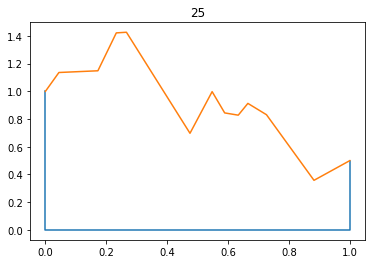

(12, 2)
[[ 3.47000000e+02 -1.31000000e+02  0.00000000e+00]
 [ 3.44000000e+02 -1.57000000e+02  3.97783001e-02]
 [ 1.40000000e+02 -1.98000000e+02  2.10221088e-01]
 [ 1.62000000e+02 -3.06000000e+02  3.56825759e-01]
 [ 1.42000000e+02 -3.15000000e+02  3.80844876e-01]
 [ 1.69000000e+02 -3.38000000e+02  4.00003914e-01]
 [ 1.90000000e+01 -3.89000000e+02  5.55932502e-01]
 [ 1.91000000e+02 -5.28000000e+02  6.66948765e-01]
 [ 1.81000000e+02 -5.68000000e+02  7.31056817e-01]
 [-2.00000000e+01 -5.69000000e+02  8.41175420e-01]
 [-1.02000000e+02 -5.84000000e+02  9.07514168e-01]
 [ 1.26000000e+02 -7.31000000e+02  1.00000000e+00]]


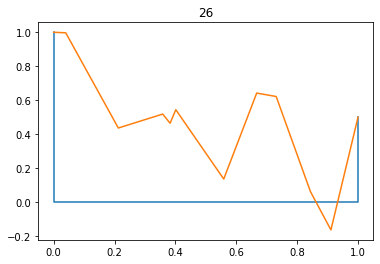

(11, 2)
[[ 1.76000000e+02 -7.70000000e+01  0.00000000e+00]
 [ 3.68000000e+02 -2.79000000e+02  2.24466290e-01]
 [ 2.95000000e+02 -2.75000000e+02  2.45083571e-01]
 [ 5.20000000e+01 -3.99000000e+02  5.13571637e-01]
 [ 3.80000000e+01 -4.71000000e+02  6.23435989e-01]
 [ 1.54000000e+02 -5.74000000e+02  7.31336468e-01]
 [ 1.94000000e+02 -6.30000000e+02  7.98355567e-01]
 [ 1.79000000e+02 -6.50000000e+02  8.32897667e-01]
 [ 1.93000000e+02 -7.41000000e+02  9.60274897e-01]
 [ 1.71000000e+02 -7.50000000e+02  9.81342092e-01]
 [ 1.50000000e+01 -7.24000000e+02  1.00000000e+00]]


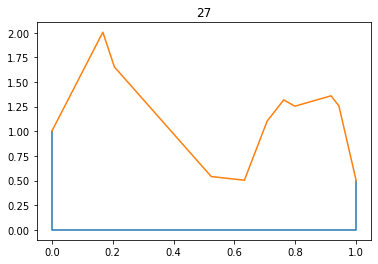

(4, 2)
[[ 5.73000000e+02 -1.00000000e+01  0.00000000e+00]
 [ 6.34000000e+02 -1.64000000e+02  2.12765763e-01]
 [ 4.00000000e+02 -6.04000000e+02  7.88542580e-01]
 [ 6.16000000e+02 -7.48000000e+02  1.00000000e+00]]


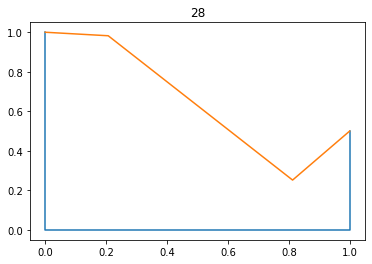

(17, 2)
[[-2.00000000e+02 -1.52000000e+02  0.00000000e+00]
 [-3.67000000e+02 -1.32000000e+02  1.58123745e-01]
 [-3.69000000e+02 -9.90000000e+01  1.96672086e-01]
 [-4.15000000e+02 -4.30000000e+01  2.96719901e-01]
 [-3.67000000e+02  3.50000000e+01  3.44974658e-01]
 [-4.57000000e+02  2.50000000e+01  4.06942718e-01]
 [-4.35000000e+02  1.04000000e+02  4.77450512e-01]
 [-4.02000000e+02  1.53000000e+02  5.05450894e-01]
 [-4.52000000e+02  1.99000000e+02  5.97561442e-01]
 [-4.52000000e+02  2.41000000e+02  6.44553887e-01]
 [-5.42000000e+02  2.41000000e+02  7.17710624e-01]
 [-6.22000000e+02  2.15000000e+02  7.53648274e-01]
 [-6.58000000e+02  2.24000000e+02  7.92980778e-01]
 [-6.82000000e+02  2.73000000e+02  8.67313761e-01]
 [-6.75000000e+02  2.91000000e+02  8.81763412e-01]
 [-7.26000000e+02  2.81000000e+02  9.12030219e-01]
 [-6.25000000e+02  4.33000000e+02  1.00000000e+00]]


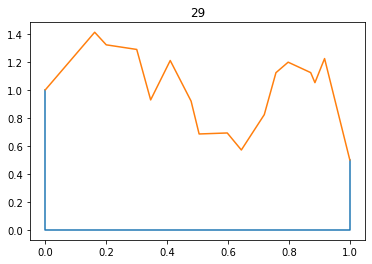

(16, 2)
[[-4.26000000e+02 -2.29000000e+02  0.00000000e+00]
 [-3.66000000e+02 -1.68000000e+02  5.41632318e-02]
 [-3.79000000e+02 -8.70000000e+01  1.75604053e-01]
 [-4.32000000e+02 -5.80000000e+01  2.44916274e-01]
 [-5.59000000e+02 -5.80000000e+01  3.12778449e-01]
 [-4.78000000e+02  2.40000000e+01  3.85404083e-01]
 [-3.77000000e+02  1.62000000e+02  5.26499314e-01]
 [-5.06000000e+02  1.36000000e+02  5.58678928e-01]
 [-5.89000000e+02  1.50000000e+02  6.22818936e-01]
 [-5.83000000e+02  1.81000000e+02  6.63431655e-01]
 [-5.23000000e+02  2.44000000e+02  7.20421906e-01]
 [-5.33000000e+02  2.54000000e+02  7.39900483e-01]
 [-6.15000000e+02  2.38000000e+02  7.61100848e-01]
 [-7.58000000e+02  2.40000000e+02  8.40339608e-01]
 [-7.49000000e+02  2.84000000e+02  8.97724911e-01]
 [-6.60000000e+02  3.90000000e+02  1.00000000e+00]]


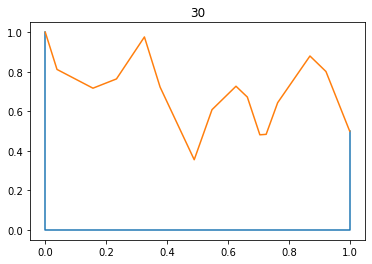

(18, 2)
[[-1.78000000e+02 -3.53000000e+02  0.00000000e+00]
 [-1.78000000e+02 -2.86000000e+02  7.24864416e-02]
 [-2.38000000e+02 -3.32000000e+02  6.80857217e-02]
 [-2.31000000e+02 -2.05000000e+02  2.00192684e-01]
 [-2.84000000e+02 -2.05000000e+02  2.40266064e-01]
 [-3.01000000e+02 -1.46000000e+02  3.16951134e-01]
 [-3.27000000e+02 -1.28000000e+02  3.56083743e-01]
 [-3.84000000e+02 -1.60000000e+02  3.64561139e-01]
 [-3.97000000e+02 -1.00000000e+02  4.39303690e-01]
 [-4.13000000e+02 -8.90000000e+01  4.63302073e-01]
 [-4.46000000e+02 -1.16000000e+02  4.59042469e-01]
 [-4.68000000e+02 -5.10000000e+01  5.45999369e-01]
 [-4.47000000e+02  8.20000000e+01  6.74012234e-01]
 [-4.71000000e+02  8.80000000e+01  6.98649993e-01]
 [-5.47000000e+02  2.60000000e+01  6.89036702e-01]
 [-5.19000000e+02  1.73000000e+02  8.26903276e-01]
 [-6.30000000e+02  1.30000000e+02  8.64309395e-01]
 [-6.12000000e+02  2.68000000e+02  1.00000000e+00]]


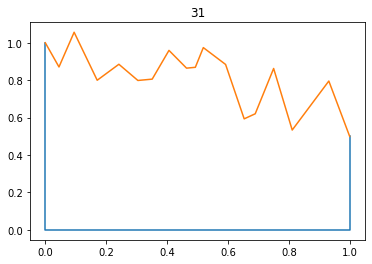

(2, 2)
[[259. 548.   0.]
 [752. 369.   1.]]


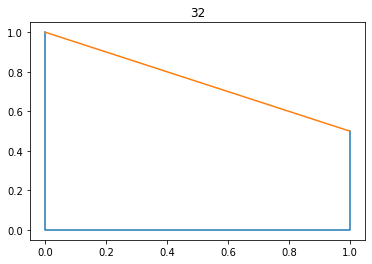

(15, 2)
[[-1.40000000e+01  7.42000000e+02  0.00000000e+00]
 [ 1.37000000e+02  4.32000000e+02  2.87255604e-01]
 [ 1.83000000e+02  5.64000000e+02  2.94579017e-01]
 [ 2.09000000e+02  5.31000000e+02  3.36824261e-01]
 [ 2.49000000e+02  3.81000000e+02  4.36956112e-01]
 [ 2.95000000e+02  3.16000000e+02  5.14040309e-01]
 [ 3.72000000e+02  3.28000000e+02  6.00293841e-01]
 [ 4.52000000e+02  5.58000000e+02  6.12876248e-01]
 [ 5.75000000e+02  4.26000000e+02  8.04189113e-01]
 [ 5.85000000e+02  4.41000000e+02  8.10631004e-01]
 [ 5.91000000e+02  4.25000000e+02  8.23349030e-01]
 [ 6.91000000e+02  4.27000000e+02  9.40177058e-01]
 [ 6.98000000e+02  4.43000000e+02  9.42738746e-01]
 [ 7.10000000e+02  4.07000000e+02  9.69591260e-01]
 [ 7.66000000e+02  5.07000000e+02  1.00000000e+00]]


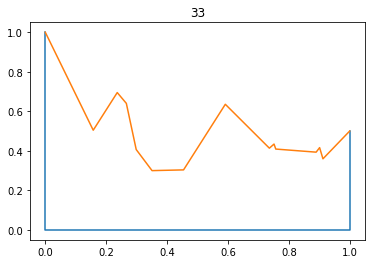

(2, 2)
[[-677. -162.    0.]
 [-628.  494.    1.]]


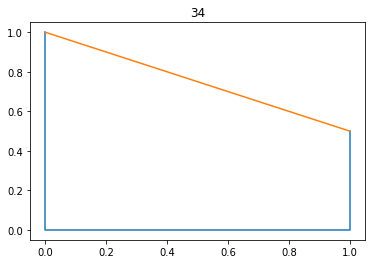

(15, 2)
[[-4.53000000e+02 -3.05000000e+02  0.00000000e+00]
 [-4.98000000e+02 -3.18000000e+02  2.32691722e-02]
 [-3.81000000e+02 -1.54000000e+02  1.49737416e-01]
 [-3.99000000e+02 -1.47000000e+02  1.76564368e-01]
 [-5.63000000e+02 -1.86000000e+02  2.73398120e-01]
 [-5.74000000e+02 -1.46000000e+02  3.41089724e-01]
 [-5.53000000e+02 -1.14000000e+02  3.67471221e-01]
 [-6.55000000e+02 -1.17000000e+02  4.58220993e-01]
 [-4.84000000e+02  8.90000000e+01  5.94676811e-01]
 [-6.92000000e+02  8.00000000e+01  7.75596089e-01]
 [-7.10000000e+02  9.60000000e+01  8.15347103e-01]
 [-6.38000000e+02  1.81000000e+02  8.70308067e-01]
 [-6.78000000e+02  1.78000000e+02  9.03277612e-01]
 [-6.85000000e+02  2.02000000e+02  9.44265351e-01]
 [-7.71000000e+02  1.85000000e+02  1.00000000e+00]]


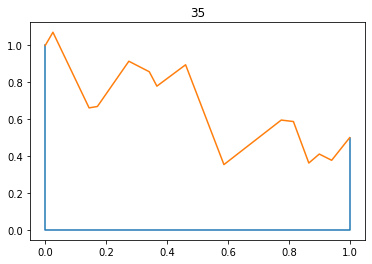

(19, 2)
[[-2.29000000e+02 -2.52000000e+02  0.00000000e+00]
 [-3.22000000e+02 -3.04000000e+02  1.06340035e-01]
 [-3.08000000e+02 -2.52000000e+02  1.15679911e-01]
 [-3.43000000e+02 -2.58000000e+02  1.63487415e-01]
 [-3.46000000e+02 -2.42000000e+02  1.77061896e-01]
 [-3.09000000e+02 -1.58000000e+02  1.71085959e-01]
 [-3.42000000e+02 -1.73000000e+02  2.10800222e-01]
 [-3.37000000e+02 -1.47000000e+02  2.18398765e-01]
 [-4.01000000e+02 -1.71000000e+02  2.98341776e-01]
 [-4.33000000e+02 -1.61000000e+02  3.50937945e-01]
 [-4.39000000e+02 -8.70000000e+01  4.02188539e-01]
 [-4.12000000e+02 -2.40000000e+01  3.98804812e-01]
 [-4.27000000e+02  9.00000000e+00  4.39706348e-01]
 [-5.55000000e+02 -3.30000000e+01  6.03035460e-01]
 [-5.50000000e+02  1.00000000e+01  6.20389425e-01]
 [-5.90000000e+02  5.30000000e+01  7.03637011e-01]
 [-6.67000000e+02  2.30000000e+01  7.99172867e-01]
 [-6.72000000e+02  3.50000000e+01  8.13380560e-01]
 [-8.21000000e+02 -2.00000000e+01  1.00000000e+00]]


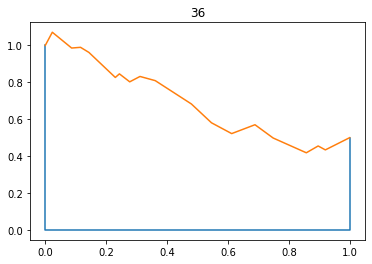

(17, 2)
[[-2.65000000e+02  1.81000000e+02  0.00000000e+00]
 [-3.35000000e+02  2.65000000e+02  4.47997753e-02]
 [-2.26000000e+02  2.79000000e+02  1.62416740e-01]
 [-2.26000000e+02  3.13000000e+02  2.06414012e-01]
 [-1.75000000e+02  3.32000000e+02  2.77555975e-01]
 [-1.94000000e+02  3.60000000e+02  2.96444908e-01]
 [-1.60000000e+02  4.41000000e+02  4.32298772e-01]
 [-1.69000000e+02  4.90000000e+02  4.87490972e-01]
 [-1.47000000e+02  4.98000000e+02  5.17925929e-01]
 [-5.40000000e+01  4.71000000e+02  5.67881791e-01]
 [-4.20000000e+01  5.11000000e+02  6.30597464e-01]
 [-5.50000000e+01  5.47000000e+02  6.65315785e-01]
 [ 9.70000000e+01  4.96000000e+02  7.38072787e-01]
 [ 1.52000000e+02  4.92000000e+02  7.83103282e-01]
 [ 1.50000000e+02  5.33000000e+02  8.34333119e-01]
 [ 9.20000000e+01  6.52000000e+02  9.35378381e-01]
 [ 9.90000000e+01  6.97000000e+02  1.00000000e+00]]


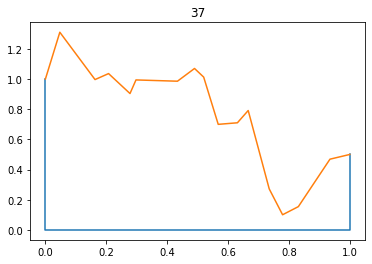

(21, 2)
[[-2.65000000e+02  2.80000000e+01  0.00000000e+00]
 [-3.51000000e+02  5.80000000e+01  2.82847653e-02]
 [-2.55000000e+02  7.10000000e+01  5.87953292e-02]
 [-3.52000000e+02  1.37000000e+02  1.33650652e-01]
 [-1.74000000e+02  1.85000000e+02  2.22134712e-01]
 [-3.36000000e+02  2.68000000e+02  3.10789987e-01]
 [-2.36000000e+02  2.81000000e+02  3.41848440e-01]
 [-1.78000000e+02  3.36000000e+02  4.23244187e-01]
 [-1.68000000e+02  3.63000000e+02  4.60671849e-01]
 [-1.92000000e+02  3.80000000e+02  4.80087662e-01]
 [-9.80000000e+01  3.89000000e+02  5.04982365e-01]
 [-9.70000000e+01  4.17000000e+02  5.42512756e-01]
 [-1.82000000e+02  5.00000000e+02  6.41714892e-01]
 [-2.64000000e+02  5.43000000e+02  6.87908776e-01]
 [-2.12000000e+02  5.84000000e+02  7.49785981e-01]
 [-2.37000000e+02  6.16000000e+02  7.89097011e-01]
 [-1.03000000e+02  6.18000000e+02  8.10122248e-01]
 [-1.18000000e+02  6.49000000e+02  8.49467520e-01]
 [-7.20000000e+01  6.65000000e+02  8.77135911e-01]
 [-2.06000000e+02  7.50

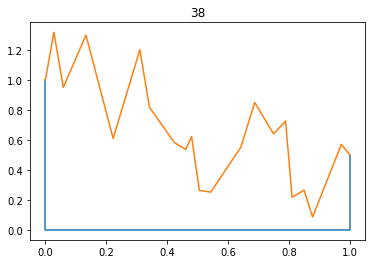

(14, 2)
[[-3.10000000e+01 -9.30000000e+01  0.00000000e+00]
 [-6.20000000e+01 -1.24000000e+02  6.14692717e-02]
 [-1.42000000e+02 -1.18000000e+02  1.57875197e-01]
 [-1.35000000e+02 -1.71000000e+02  1.87407448e-01]
 [-1.83000000e+02 -1.84000000e+02  2.57261770e-01]
 [-1.68000000e+02 -2.99000000e+02  3.21578794e-01]
 [-2.08000000e+02 -2.98000000e+02  3.71228837e-01]
 [-1.41000000e+02 -4.08000000e+02  3.66442503e-01]
 [-1.84000000e+02 -4.14000000e+02  4.24935345e-01]
 [-1.01000000e+02 -4.94000000e+02  3.78293373e-01]
 [-3.30000000e+02 -5.09000000e+02  6.77535238e-01]
 [-3.71000000e+02 -5.33000000e+02  7.46533125e-01]
 [-4.10000000e+02 -5.31000000e+02  7.94200288e-01]
 [-6.28000000e+02 -4.36000000e+02  1.00000000e+00]]


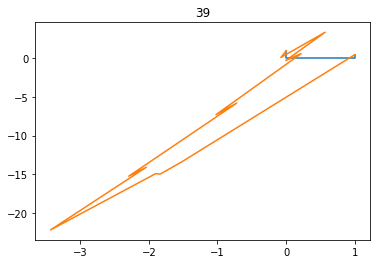

(4, 2)
[[1.13000000e+02 5.30000000e+02 0.00000000e+00]
 [1.93000000e+02 3.28000000e+02 2.55683172e-01]
 [2.99000000e+02 1.84000000e+02 4.89181278e-01]
 [6.88000000e+02 6.20000000e+01 1.00000000e+00]]


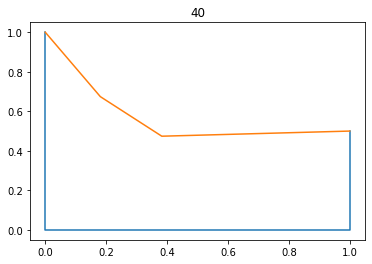

(9, 2)
[[1.90000000e+01 4.71000000e+02 0.00000000e+00]
 [1.03000000e+02 4.48000000e+02 1.04992119e-01]
 [1.61000000e+02 4.91000000e+02 1.83178715e-01]
 [2.24000000e+02 6.03000000e+02 2.74417439e-01]
 [2.89000000e+02 5.56000000e+02 3.52838338e-01]
 [3.58000000e+02 3.44000000e+02 4.20414142e-01]
 [4.47000000e+02 2.21000000e+02 5.22121110e-01]
 [5.98000000e+02 2.09000000e+02 7.13693755e-01]
 [7.98000000e+02 5.30000000e+02 1.00000000e+00]]


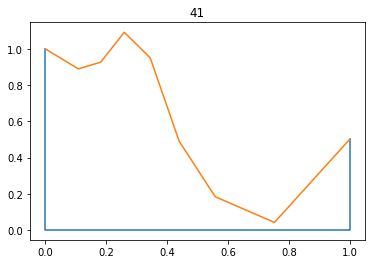

(5, 2)
[[ 1.83000000e+02 -2.07000000e+02  0.00000000e+00]
 [ 2.03000000e+02 -4.91000000e+02  3.32778435e-01]
 [ 1.22000000e+02 -6.14000000e+02  5.72084570e-01]
 [-1.19000000e+02 -6.82000000e+02  9.12679839e-01]
 [-2.13000000e+02 -6.72000000e+02  1.00000000e+00]]


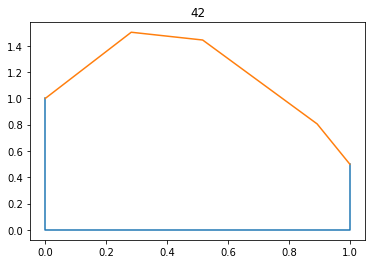

(18, 2)
[[ 1.13000000e+02 -4.73000000e+02  0.00000000e+00]
 [ 4.10000000e+01 -3.51000000e+02  2.83706251e-02]
 [-3.00000000e+00 -3.38000000e+02  7.97949854e-02]
 [-7.80000000e+01 -4.17000000e+02  2.23467595e-01]
 [-1.00000000e+02 -3.82000000e+02  2.33397730e-01]
 [-1.22000000e+02 -3.84000000e+02  2.63816836e-01]
 [-1.83000000e+02 -5.27000000e+02  4.24276995e-01]
 [-2.30000000e+02 -4.71000000e+02  4.55886884e-01]
 [-2.38000000e+02 -5.22000000e+02  4.94787199e-01]
 [-2.94000000e+02 -5.59000000e+02  5.89887500e-01]
 [-3.94000000e+02 -4.21000000e+02  6.46703695e-01]
 [-4.26000000e+02 -4.29000000e+02  6.93768788e-01]
 [-4.50000000e+02 -4.82000000e+02  7.55094139e-01]
 [-4.55000000e+02 -5.79000000e+02  8.15470193e-01]
 [-4.70000000e+02 -6.11000000e+02  8.53175561e-01]
 [-4.98000000e+02 -6.07000000e+02  8.88266203e-01]
 [-5.17000000e+02 -6.38000000e+02  9.30747196e-01]
 [-5.27000000e+02 -7.39000000e+02  1.00000000e+00]]


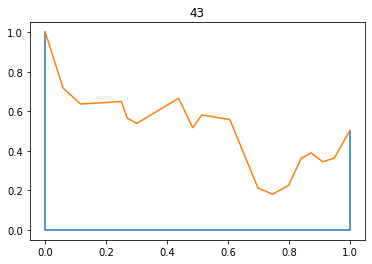

(11, 2)
[[-2.86000000e+02  1.46000000e+02  0.00000000e+00]
 [-1.88000000e+02  1.16000000e+02 -8.50748288e-03]
 [-1.45000000e+02  1.19000000e+02  1.25808537e-02]
 [-1.55000000e+02  2.15000000e+02  1.56170931e-01]
 [-1.38000000e+02  2.30000000e+02  1.85721658e-01]
 [-1.85000000e+02  3.02000000e+02  2.78274354e-01]
 [-2.93000000e+02  4.09000000e+02  4.01194455e-01]
 [-2.73000000e+02  4.77000000e+02  5.13284800e-01]
 [-2.40000000e+01  5.64000000e+02  7.42325479e-01]
 [ 5.60000000e+01  5.52000000e+02  7.54560622e-01]
 [-1.33000000e+02  7.59000000e+02  1.00000000e+00]]


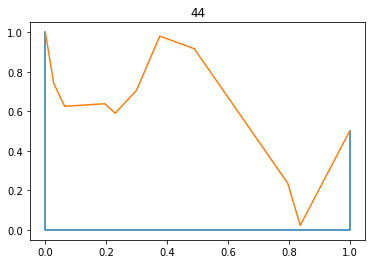

(13, 2)
[[ 3.45000000e+02  2.53000000e+02  0.00000000e+00]
 [ 2.78000000e+02  1.35000000e+02  1.48520397e-01]
 [ 2.85000000e+02  9.70000000e+01  2.14516007e-01]
 [ 4.39000000e+02  5.00000000e+01  3.88541588e-01]
 [ 4.44000000e+02  2.40000000e+01  4.33830319e-01]
 [ 3.94000000e+02 -5.00000000e+01  5.21895103e-01]
 [ 4.38000000e+02 -3.30000000e+01  5.22334065e-01]
 [ 5.18000000e+02 -3.90000000e+01  5.82910770e-01]
 [ 4.88000000e+02 -9.40000000e+01  6.52917581e-01]
 [ 5.83000000e+02 -8.20000000e+01  6.93877242e-01]
 [ 5.37000000e+02 -2.08000000e+02  8.68705063e-01]
 [ 5.37000000e+02 -2.69000000e+02  9.67501703e-01]
 [ 5.55000000e+02 -2.82000000e+02  1.00000000e+00]]


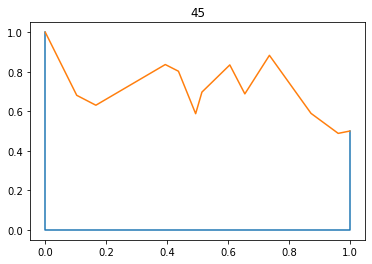

(18, 2)
[[ 2.66000000e+02 -2.00000000e+02  0.00000000e+00]
 [ 2.88000000e+02 -3.04000000e+02  7.51791049e-02]
 [ 2.76000000e+02 -3.12000000e+02  9.53547626e-02]
 [ 1.91000000e+02 -2.81000000e+02  1.55400126e-01]
 [ 1.76000000e+02 -3.01000000e+02  1.90072042e-01]
 [ 9.20000000e+01 -2.97000000e+02  2.74587584e-01]
 [ 9.60000000e+01 -3.27000000e+02  2.98740021e-01]
 [ 4.90000000e+01 -3.21000000e+02  3.42472597e-01]
 [ 1.32000000e+02 -4.55000000e+02  3.81888670e-01]
 [ 3.90000000e+01 -4.62000000e+02  4.86262128e-01]
 [ 7.70000000e+01 -5.29000000e+02  5.09649184e-01]
 [ 1.40000000e+01 -5.35000000e+02  5.81542950e-01]
 [-1.73000000e+02 -4.65000000e+02  7.11941328e-01]
 [-1.29000000e+02 -5.88000000e+02  7.81954617e-01]
 [-1.70000000e+02 -5.91000000e+02  8.27887411e-01]
 [-1.40000000e+02 -6.49000000e+02  8.51176547e-01]
 [-2.10000000e+02 -6.18000000e+02  8.95454682e-01]
 [-2.60000000e+02 -6.73000000e+02  1.00000000e+00]]


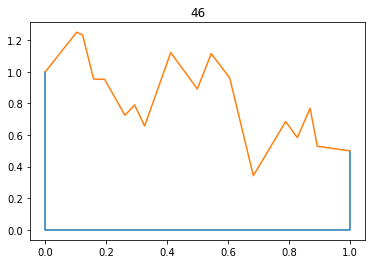

(17, 2)
[[ 2.19000000e+02  2.34000000e+02  0.00000000e+00]
 [ 1.85000000e+02  1.74000000e+02  1.22493580e-02]
 [ 1.91000000e+02  1.54000000e+02  3.49887997e-02]
 [ 3.07000000e+02  2.03000000e+02  1.19953013e-01]
 [ 2.89000000e+02  1.11000000e+02  1.75473966e-01]
 [ 3.46000000e+02  7.00000000e+01  2.70201606e-01]
 [ 3.92000000e+02  9.60000000e+01  2.98546686e-01]
 [ 4.42000000e+02  7.60000000e+01  3.68644485e-01]
 [ 3.85000000e+02 -5.80000000e+01  4.16379828e-01]
 [ 3.87000000e+02 -9.60000000e+01  4.49467300e-01]
 [ 5.71000000e+02 -3.30000000e+01  5.96224663e-01]
 [ 5.97000000e+02 -1.10000000e+02  6.86892859e-01]
 [ 5.81000000e+02 -1.79000000e+02  7.25842758e-01]
 [ 6.04000000e+02 -2.49000000e+02  8.07583456e-01]
 [ 6.65000000e+02 -2.50000000e+02  8.74053434e-01]
 [ 7.46000000e+02 -2.10000000e+02  9.28672895e-01]
 [ 8.10000000e+02 -2.13000000e+02  1.00000000e+00]]


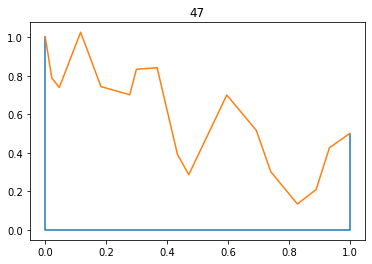

(2, 2)
[[ 370.  446.    0.]
 [ 550. -252.    1.]]


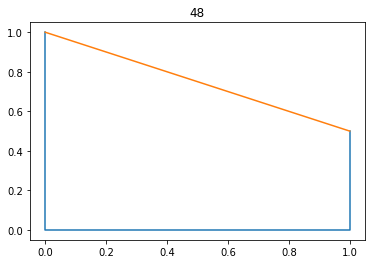

(15, 2)
[[ 5.01000000e+02  1.14000000e+02  0.00000000e+00]
 [ 3.90000000e+02  7.20000000e+01  1.30651860e-02]
 [ 4.15000000e+02 -5.50000000e+01  1.86897023e-01]
 [ 4.87000000e+02 -9.50000000e+01  2.65531601e-01]
 [ 6.07000000e+02 -1.01000000e+02  3.17999469e-01]
 [ 6.32000000e+02 -1.27000000e+02  3.60992307e-01]
 [ 5.56000000e+02 -1.98000000e+02  4.24661243e-01]
 [ 5.74000000e+02 -2.53000000e+02  5.02614491e-01]
 [ 4.41000000e+02 -3.30000000e+02  5.52825794e-01]
 [ 5.09000000e+02 -3.58000000e+02  6.14425303e-01]
 [ 5.09000000e+02 -4.12000000e+02  6.84378827e-01]
 [ 7.41000000e+02 -4.50000000e+02  8.20016207e-01]
 [ 7.70000000e+02 -4.69000000e+02  8.55430837e-01]
 [ 8.10000000e+02 -5.43000000e+02  9.66191492e-01]
 [ 7.06000000e+02 -5.99000000e+02  1.00000000e+00]]


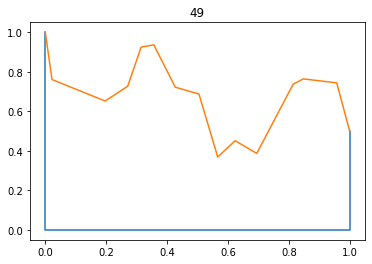

(18, 2)
[[-4.47000000e+02  1.58000000e+02  0.00000000e+00]
 [-2.72000000e+02  1.59000000e+02  1.33781726e-01]
 [-3.46000000e+02  2.44000000e+02  1.90409096e-01]
 [-3.38000000e+02  2.58000000e+02  2.15016326e-01]
 [-2.97000000e+02  2.63000000e+02  2.52674750e-01]
 [-3.06000000e+02  2.82000000e+02  2.71040509e-01]
 [-4.73000000e+02  4.16000000e+02  3.22208922e-01]
 [-2.95000000e+02  4.58000000e+02  5.12592399e-01]
 [-3.06000000e+02  4.83000000e+02  5.37395257e-01]
 [-4.04000000e+02  5.54000000e+02  5.57305082e-01]
 [-1.95000000e+02  5.73000000e+02  7.40673892e-01]
 [-1.79000000e+02  5.91000000e+02  7.76636872e-01]
 [-2.01000000e+02  6.29000000e+02  8.10340812e-01]
 [-1.01000000e+02  6.40000000e+02  9.00606913e-01]
 [-1.17000000e+02  6.53000000e+02  9.05723521e-01]
 [-8.20000000e+01  6.77000000e+02  9.64018389e-01]
 [-1.67000000e+02  7.26000000e+02  9.64614589e-01]
 [-1.22000000e+02  7.27000000e+02  1.00000000e+00]]


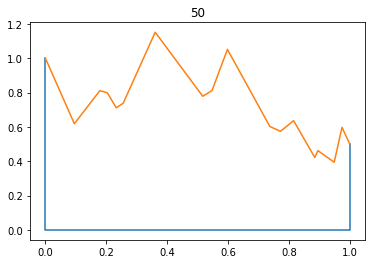

(17, 2)
[[-2.70000000e+02  4.80000000e+01  0.00000000e+00]
 [-3.26000000e+02  7.60000000e+01  2.71156244e-02]
 [-3.66000000e+02  1.88000000e+02  1.65069232e-01]
 [-4.04000000e+02  2.31000000e+02  2.14404416e-01]
 [-4.81000000e+02  2.77000000e+02  2.61355680e-01]
 [-4.38000000e+02  2.97000000e+02  2.94027038e-01]
 [-1.27000000e+02  3.48000000e+02  4.09610930e-01]
 [-2.51000000e+02  4.21000000e+02  4.83831347e-01]
 [-2.34000000e+02  4.44000000e+02  5.16202395e-01]
 [-9.10000000e+01  4.65000000e+02  5.66190501e-01]
 [-8.80000000e+01  5.13000000e+02  6.28541928e-01]
 [-1.56000000e+02  5.56000000e+02  6.73068779e-01]
 [-1.36000000e+02  5.62000000e+02  6.84008159e-01]
 [-2.58000000e+02  6.40000000e+02  7.64993985e-01]
 [-2.81000000e+02  7.37000000e+02  8.86337754e-01]
 [-2.67000000e+02  8.18000000e+02  9.92988269e-01]
 [-1.75000000e+02  8.12000000e+02  1.00000000e+00]]


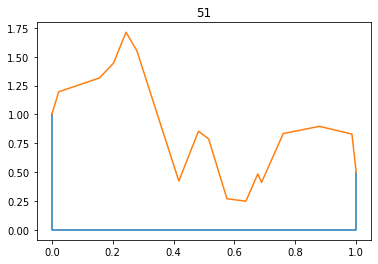

(18, 2)
[[-2.85000000e+02 -1.83000000e+02  0.00000000e+00]
 [-2.47000000e+02 -1.20000000e+02  4.89839411e-02]
 [-2.36000000e+02  2.80000000e+01  2.31808717e-01]
 [-2.66000000e+02  4.60000000e+01  2.81170601e-01]
 [-3.26000000e+02  3.30000000e+01  3.16212078e-01]
 [-3.31000000e+02  5.90000000e+01  3.54330747e-01]
 [-4.31000000e+02  3.00000000e+01  4.03202524e-01]
 [-4.20000000e+02  5.30000000e+01  4.23572470e-01]
 [-4.76000000e+02  4.80000000e+01  4.65548604e-01]
 [-4.22000000e+02  1.79000000e+02  5.89058164e-01]
 [-4.40000000e+02  2.10000000e+02  6.44927996e-01]
 [-5.14000000e+02  2.18000000e+02  7.19380465e-01]
 [-5.28000000e+02  2.41000000e+02  7.61390735e-01]
 [-6.21000000e+02  2.11000000e+02  8.02903583e-01]
 [-6.32000000e+02  2.50000000e+02  8.63111232e-01]
 [-6.91000000e+02  2.42000000e+02  9.03785289e-01]
 [-6.80000000e+02  3.01000000e+02  9.70942226e-01]
 [-6.40000000e+02  3.50000000e+02  1.00000000e+00]]


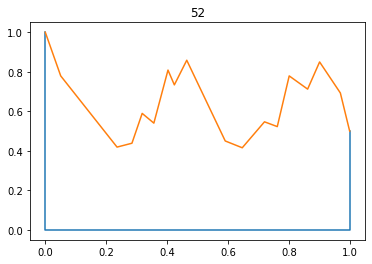

(13, 2)
[[-8.10000000e+01 -1.56000000e+02  0.00000000e+00]
 [-1.36000000e+02 -1.53000000e+02  6.88462926e-02]
 [-2.19000000e+02 -2.30000000e+02  1.02850645e-01]
 [-2.93000000e+02 -2.60000000e+02  1.66301816e-01]
 [-3.40000000e+02 -1.94000000e+02  2.79516254e-01]
 [-3.81000000e+02 -2.05000000e+02  3.19490886e-01]
 [-3.76000000e+02 -1.09000000e+02  3.95763944e-01]
 [-4.15000000e+02 -2.90000000e+01  5.11340251e-01]
 [-5.38000000e+02  1.35000000e+02  8.00146523e-01]
 [-5.76000000e+02  1.24000000e+02  8.36506184e-01]
 [-5.89000000e+02  1.66000000e+02  8.88176440e-01]
 [-6.47000000e+02  1.08000000e+02  9.08344177e-01]
 [-6.32000000e+02  2.36000000e+02  1.00000000e+00]]


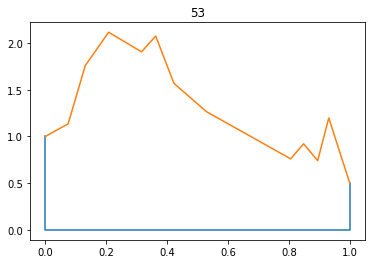

(3, 2)
[[ 1.40000000e+02 -1.51000000e+02  0.00000000e+00]
 [ 1.51000000e+02 -4.04000000e+02  2.54432201e-01]
 [-3.36000000e+02 -6.42000000e+02  1.00000000e+00]]


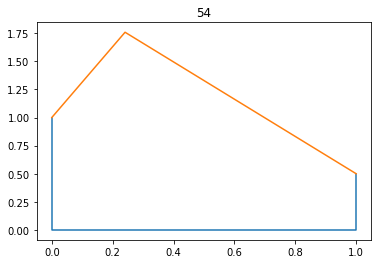

(16, 2)
[[-2.29000000e+02  1.09000000e+02  0.00000000e+00]
 [-2.85000000e+02  1.83000000e+02  3.68595515e-02]
 [-2.85000000e+02  2.04000000e+02  5.99344392e-02]
 [-2.45000000e+02  2.10000000e+02  9.82786626e-02]
 [-2.55000000e+02  2.24000000e+02  1.05724072e-01]
 [-1.94000000e+02  3.34000000e+02  2.75013413e-01]
 [-1.80000000e+02  3.36000000e+02  2.88324011e-01]
 [-1.82000000e+02  3.55000000e+02  3.07613721e-01]
 [-3.20000000e+01  4.33000000e+02  5.12388190e-01]
 [-1.51000000e+02  5.68000000e+02  5.66266344e-01]
 [-1.21000000e+02  6.31000000e+02  6.59304556e-01]
 [-5.60000000e+01  6.42000000e+02  7.22987424e-01]
 [ 4.20000000e+01  6.28000000e+02  7.85395092e-01]
 [ 6.80000000e+01  6.38000000e+02  8.17021542e-01]
 [ 1.20000000e+01  7.03000000e+02  8.43991856e-01]
 [ 2.03000000e+02  7.07000000e+02  1.00000000e+00]]


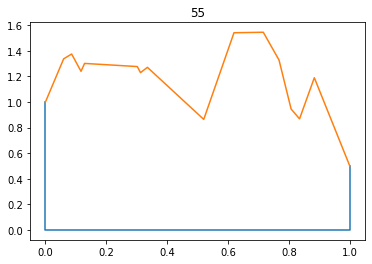

(8, 2)
[[-1.18000000e+02 -3.41000000e+02  0.00000000e+00]
 [-3.18000000e+02 -4.01000000e+02  2.25806002e-01]
 [-3.43000000e+02 -4.22000000e+02  2.46504885e-01]
 [-3.39000000e+02 -2.25000000e+02  3.51156210e-01]
 [-4.34000000e+02 -2.02000000e+02  4.87127664e-01]
 [-6.35000000e+02 -2.97000000e+02  6.94715861e-01]
 [-7.46000000e+02 -2.77000000e+02  8.49755377e-01]
 [-7.69000000e+02 -6.10000000e+01  1.00000000e+00]]


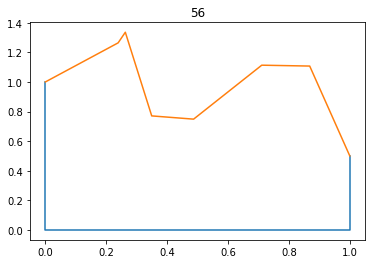

(17, 2)
[[-1.35000000e+02  1.15000000e+02  0.00000000e+00]
 [-1.51000000e+02  1.83000000e+02  5.08025841e-02]
 [-1.13000000e+02  2.36000000e+02  1.35517025e-01]
 [-1.21000000e+02  3.54000000e+02  2.41343159e-01]
 [-9.50000000e+01  3.79000000e+02  2.88521890e-01]
 [-6.30000000e+01  3.81000000e+02  3.19043248e-01]
 [ 2.60000000e+01  3.59000000e+02  3.77541373e-01]
 [ 7.00000000e+01  4.19000000e+02  4.74321600e-01]
 [ 6.60000000e+01  4.52000000e+02  5.02341263e-01]
 [ 1.21000000e+02  4.50000000e+02  5.49593775e-01]
 [ 1.39000000e+02  5.66000000e+02  6.76747797e-01]
 [ 1.58000000e+02  5.85000000e+02  7.11924229e-01]
 [ 1.91000000e+02  5.81000000e+02  7.37594907e-01]
 [ 2.41000000e+02  6.75000000e+02  8.72291761e-01]
 [ 2.83000000e+02  6.95000000e+02  9.28986539e-01]
 [ 3.53000000e+02  6.67000000e+02  9.64754935e-01]
 [ 3.86000000e+02  6.73000000e+02  1.00000000e+00]]


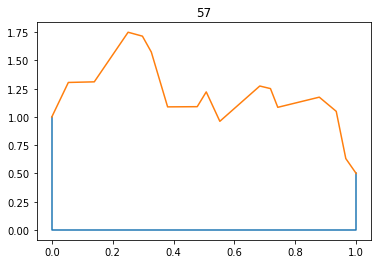

(6, 2)
[[-3.89000000e+02  2.25000000e+02  0.00000000e+00]
 [-2.86000000e+02  1.76000000e+02  9.42502167e-02]
 [-3.86000000e+02  3.31000000e+02  8.84137533e-02]
 [-2.05000000e+02  3.45000000e+02  3.33868824e-01]
 [-6.80000000e+01  3.98000000e+02  5.53470095e-01]
 [ 1.71000000e+02  5.70000000e+02  1.00000000e+00]]


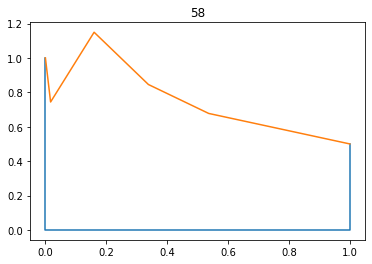

(23, 2)
[[-3.46000000e+02  1.60000000e+01  0.00000000e+00]
 [-4.15000000e+02  3.20000000e+01  2.97669236e-02]
 [-3.89000000e+02  5.30000000e+01  5.13792437e-02]
 [-4.76000000e+02  9.30000000e+01  1.12991803e-01]
 [-4.22000000e+02  1.18000000e+02  1.35269072e-01]
 [-5.48000000e+02  1.61000000e+02  2.06366132e-01]
 [-4.89000000e+02  1.86000000e+02  2.27894585e-01]
 [-5.64000000e+02  2.16000000e+02  2.75564195e-01]
 [-5.55000000e+02  2.99000000e+02  3.75026396e-01]
 [-3.08000000e+02  3.37000000e+02  3.84188905e-01]
 [-3.46000000e+02  3.64000000e+02  4.22673542e-01]
 [-2.61000000e+02  3.77000000e+02  4.25733203e-01]
 [-4.43000000e+02  4.42000000e+02  5.31937740e-01]
 [-2.81000000e+02  4.75000000e+02  5.47757222e-01]
 [-2.96000000e+02  5.10000000e+02  5.92513939e-01]
 [-4.45000000e+02  6.03000000e+02  7.27784509e-01]
 [-4.28000000e+02  6.10000000e+02  7.33740589e-01]
 [-4.46000000e+02  6.28000000e+02  7.58298751e-01]
 [-4.30000000e+02  6.77000000e+02  8.15416918e-01]
 [-2.85000000e+02  6.91

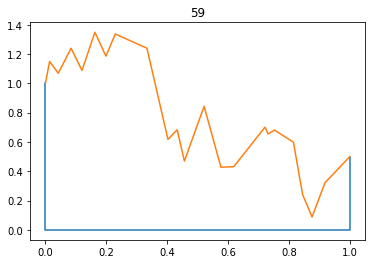

(3, 2)
[[ 4.93000000e+02 -3.20000000e+01  0.00000000e+00]
 [ 5.19000000e+02 -1.00000000e+02  1.03373314e-01]
 [ 6.14000000e+02 -7.13000000e+02  1.00000000e+00]]


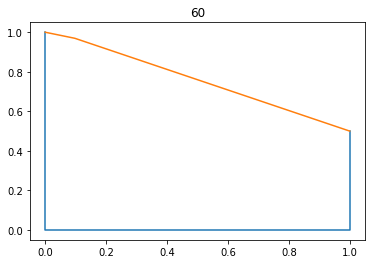

(19, 2)
[[-3.39000000e+02 -1.84000000e+02  0.00000000e+00]
 [-4.65000000e+02 -2.04000000e+02  1.11468938e-01]
 [-4.60000000e+02 -1.92000000e+02  1.24332426e-01]
 [-5.38000000e+02 -2.02000000e+02  1.97009851e-01]
 [-5.42000000e+02 -1.48000000e+02  2.84828103e-01]
 [-5.20000000e+02 -1.04000000e+02  3.27852613e-01]
 [-6.36000000e+02 -1.08000000e+02  4.52707766e-01]
 [-6.24000000e+02 -6.50000000e+01  5.05484985e-01]
 [-5.77000000e+02 -1.10000000e+01  5.35697183e-01]
 [-5.51000000e+02  7.20000000e+01  6.34364776e-01]
 [-5.71000000e+02  8.60000000e+01  6.78551715e-01]
 [-6.24000000e+02  8.30000000e+01  7.33789045e-01]
 [-6.10000000e+02  1.07000000e+02  7.54997898e-01]
 [-6.40000000e+02  1.07000000e+02  7.88883812e-01]
 [-5.77000000e+02  1.74000000e+02  8.21077258e-01]
 [-5.70000000e+02  1.94000000e+02  8.44022444e-01]
 [-6.02000000e+02  2.02000000e+02  8.92508179e-01]
 [-5.59000000e+02  2.48000000e+02  9.14897739e-01]
 [-6.48000000e+02  2.38000000e+02  1.00000000e+00]]


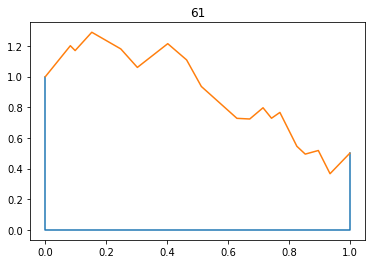

(13, 2)
[[-2.60000000e+01 -5.18000000e+02  0.00000000e+00]
 [-4.80000000e+01 -4.18000000e+02  6.94747936e-02]
 [-6.70000000e+01 -3.92000000e+02  1.04240295e-01]
 [-8.60000000e+01 -4.36000000e+02  1.09741788e-01]
 [-1.38000000e+02 -2.87000000e+02  2.37431934e-01]
 [-1.66000000e+02 -3.23000000e+02  2.57597049e-01]
 [-2.20000000e+02 -4.65000000e+02  2.66147901e-01]
 [-2.46000000e+02 -3.48000000e+02  3.47760408e-01]
 [-3.12000000e+02 -4.46000000e+02  3.89797998e-01]
 [-5.50000000e+02 -2.21000000e+02  7.83189882e-01]
 [-6.35000000e+02 -4.03000000e+02  8.14006675e-01]
 [-6.86000000e+02 -1.51000000e+02  9.83499034e-01]
 [-7.42000000e+02 -2.80000000e+02  1.00000000e+00]]


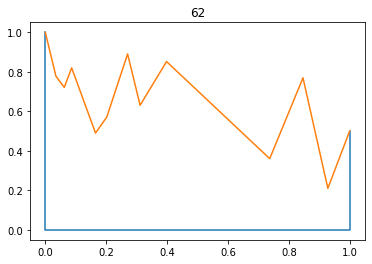

(15, 2)
[[-2.30000000e+02 -3.00000000e+02  0.00000000e+00]
 [-1.63000000e+02 -1.36000000e+02  2.03003644e-02]
 [-2.24000000e+02 -1.51000000e+02  9.82257886e-02]
 [-2.39000000e+02 -1.29000000e+02  1.35826554e-01]
 [-4.06000000e+02 -2.49000000e+02  2.92505613e-01]
 [-3.90000000e+02 -1.87000000e+02  3.13744617e-01]
 [-4.03000000e+02 -1.69000000e+02  3.45566312e-01]
 [-3.59000000e+02 -2.40000000e+01  3.85670114e-01]
 [-3.97000000e+02 -3.10000000e+01  4.35896492e-01]
 [-3.90000000e+02  3.20000000e+01  4.70939007e-01]
 [-5.74000000e+02 -7.90000000e+01  6.58795598e-01]
 [-6.07000000e+02 -6.00000000e+01  7.20414473e-01]
 [-6.24000000e+02  4.90000000e+01  8.23370265e-01]
 [-6.65000000e+02  6.40000000e+01  8.93749770e-01]
 [-7.83000000e+02 -2.70000000e+01  1.00000000e+00]]


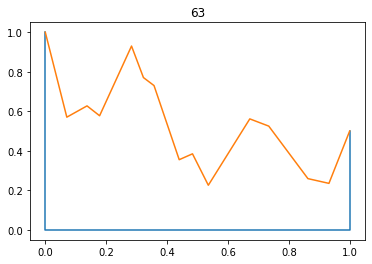

(16, 2)
[[1.60000000e+02 4.71000000e+02 0.00000000e+00]
 [1.30000000e+02 3.13000000e+02 6.43765123e-02]
 [1.66000000e+02 2.96000000e+02 1.31462359e-01]
 [2.58000000e+02 2.88000000e+02 2.78141294e-01]
 [2.94000000e+02 3.01000000e+02 3.24268139e-01]
 [3.61000000e+02 3.91000000e+02 3.64141363e-01]
 [3.68000000e+02 3.75000000e+02 3.86054596e-01]
 [4.06000000e+02 4.27000000e+02 4.08001908e-01]
 [4.42000000e+02 4.17000000e+02 4.70197321e-01]
 [4.46000000e+02 3.04000000e+02 5.55277238e-01]
 [4.63000000e+02 2.83000000e+02 5.96019494e-01]
 [5.25000000e+02 3.71000000e+02 6.29622056e-01]
 [5.46000000e+02 1.01000000e+02 8.50458372e-01]
 [6.14000000e+02 1.79000000e+02 9.00248782e-01]
 [6.83000000e+02 1.97000000e+02 9.93490781e-01]
 [7.00000000e+02 2.25000000e+02 1.00000000e+00]]


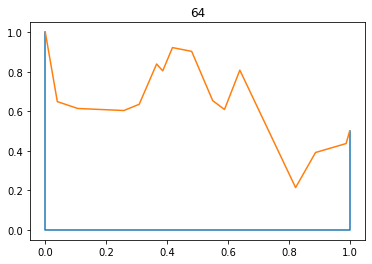

(13, 2)
[[-3.30000000e+01  2.56000000e+02  0.00000000e+00]
 [-2.50000000e+01  7.59000000e+02  2.22492300e-01]
 [-8.00000000e+00  7.24000000e+02  2.29712256e-01]
 [ 9.00000000e+00  7.21000000e+02  2.50428702e-01]
 [ 1.57000000e+02  3.42000000e+02  2.81950110e-01]
 [ 2.08000000e+02  3.66000000e+02  3.58017703e-01]
 [ 2.56000000e+02  7.54000000e+02  5.83728738e-01]
 [ 3.87000000e+02  5.64000000e+02  6.72982047e-01]
 [ 3.98000000e+02  6.21000000e+02  7.11246150e-01]
 [ 4.09000000e+02  6.00000000e+02  7.16612559e-01]
 [ 5.17000000e+02  7.40000000e+02  9.15308416e-01]
 [ 6.38000000e+02  4.71000000e+02  9.58311829e-01]
 [ 6.66000000e+02  4.84000000e+02  1.00000000e+00]]


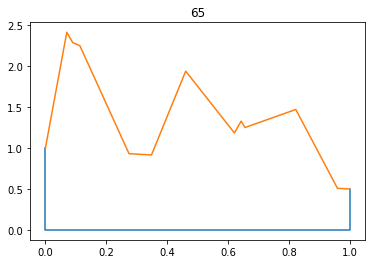

(16, 2)
[[ 2.61000000e+02 -1.64000000e+02  0.00000000e+00]
 [ 3.50000000e+02 -2.45000000e+02  3.80149813e-02]
 [ 3.29000000e+02 -2.60000000e+02  8.01498127e-02]
 [ 3.48000000e+02 -2.88000000e+02  1.04307116e-01]
 [ 2.39000000e+02 -2.68000000e+02  1.76404494e-01]
 [ 2.44000000e+02 -2.85000000e+02  1.97191011e-01]
 [ 2.31000000e+02 -2.85000000e+02  2.09363296e-01]
 [ 3.29000000e+02 -4.61000000e+02  3.81273408e-01]
 [ 6.70000000e+01 -4.00000000e+02  5.35205993e-01]
 [ 1.07000000e+02 -4.86000000e+02  6.26591760e-01]
 [ 7.60000000e+01 -4.79000000e+02  6.45131086e-01]
 [ 5.90000000e+01 -5.03000000e+02  6.97003745e-01]
 [ 3.70000000e+01 -5.04000000e+02  7.19101124e-01]
 [ 1.35000000e+02 -6.64000000e+02  8.67041199e-01]
 [-4.80000000e+01 -6.07000000e+02  9.52996255e-01]
 [-3.90000000e+01 -6.44000000e+02  1.00000000e+00]]


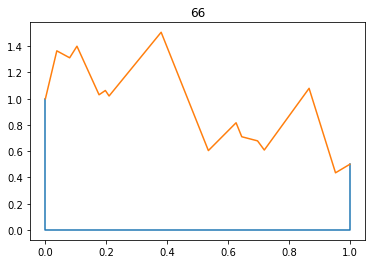

(15, 2)
[[ 1.32000000e+02 -1.35000000e+02  0.00000000e+00]
 [ 1.97000000e+02 -2.83000000e+02  1.12264611e-01]
 [ 1.74000000e+02 -3.19000000e+02  1.74182889e-01]
 [ 6.70000000e+01 -3.18000000e+02  2.68453049e-01]
 [ 3.80000000e+01 -3.47000000e+02  3.27670571e-01]
 [ 1.09000000e+02 -5.51000000e+02  4.98995954e-01]
 [ 4.80000000e+01 -5.38000000e+02  5.38441823e-01]
 [ 5.20000000e+01 -5.78000000e+02  5.80882883e-01]
 [-9.90000000e+01 -5.13000000e+02  6.40778241e-01]
 [-1.13000000e+02 -5.28000000e+02  6.70516215e-01]
 [-1.83000000e+02 -5.03000000e+02  7.04185643e-01]
 [-8.90000000e+01 -6.90000000e+02  8.35446631e-01]
 [-1.13000000e+02 -7.07000000e+02  8.76402805e-01]
 [-1.11000000e+02 -7.72000000e+02  9.49382533e-01]
 [-2.89000000e+02 -6.78000000e+02  1.00000000e+00]]


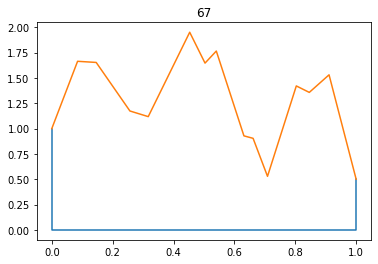

(17, 2)
[[3.00000000e+00 3.41000000e+02 0.00000000e+00]
 [7.30000000e+01 6.11000000e+02 2.51044483e-01]
 [1.31000000e+02 6.05000000e+02 3.08036373e-01]
 [1.71000000e+02 7.56000000e+02 4.49330302e-01]
 [2.14000000e+02 6.77000000e+02 4.42571885e-01]
 [2.65000000e+02 4.94000000e+02 3.75847874e-01]
 [2.87000000e+02 4.69000000e+02 3.82526419e-01]
 [3.18000000e+02 4.88000000e+02 4.27586631e-01]
 [3.66000000e+02 5.98000000e+02 5.50331777e-01]
 [4.04000000e+02 5.05000000e+02 5.29116491e-01]
 [4.36000000e+02 6.00000000e+02 6.25190464e-01]
 [4.93000000e+02 5.26000000e+02 6.36427869e-01]
 [5.31000000e+02 4.11000000e+02 6.00749570e-01]
 [5.83000000e+02 5.20000000e+02 7.27039813e-01]
 [6.00000000e+02 5.02000000e+02 7.33067093e-01]
 [6.18000000e+02 5.30000000e+02 7.70385844e-01]
 [6.87000000e+02 7.69000000e+02 1.00000000e+00]]


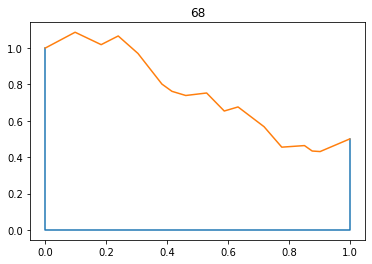

(17, 2)
[[-4.35000000e+02  8.80000000e+01  0.00000000e+00]
 [-3.01000000e+02  9.60000000e+01  1.06572928e-01]
 [-2.53000000e+02  1.85000000e+02  2.20102452e-01]
 [-2.57000000e+02  2.21000000e+02  2.48624491e-01]
 [-3.19000000e+02  2.57000000e+02  2.34047263e-01]
 [-4.06000000e+02  3.52000000e+02  2.52508590e-01]
 [-3.47000000e+02  3.96000000e+02  3.34844109e-01]
 [-3.72000000e+02  4.47000000e+02  3.60883909e-01]
 [-1.90000000e+02  4.54000000e+02  5.02250353e-01]
 [-1.50000000e+02  5.06000000e+02  5.77465902e-01]
 [-1.80000000e+01  5.35000000e+02  7.00924384e-01]
 [-1.30000000e+01  5.63000000e+02  7.29135485e-01]
 [-1.00000000e+02  6.15000000e+02  7.09978498e-01]
 [-1.19000000e+02  6.69000000e+02  7.43101377e-01]
 [-4.10000000e+01  7.57000000e+02  8.78048780e-01]
 [-6.00000000e+00  7.68000000e+02  9.13680250e-01]
 [ 1.29000000e+02  7.52000000e+02  1.00000000e+00]]


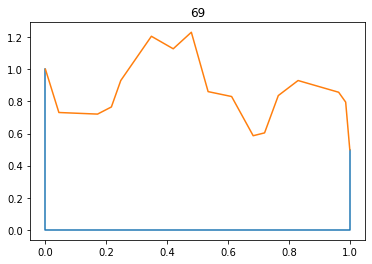

(18, 2)
[[ 2.48000000e+02  1.34000000e+02  0.00000000e+00]
 [ 3.12000000e+02  1.52000000e+02  3.84671740e-02]
 [ 3.05000000e+02  1.25000000e+02  6.28463813e-02]
 [ 4.25000000e+02  1.40000000e+02  1.56385482e-01]
 [ 4.25000000e+02  7.70000000e+01  2.28333664e-01]
 [ 4.36000000e+02  5.60000000e+01  2.62461106e-01]
 [ 4.61000000e+02  5.80000000e+01  2.83233208e-01]
 [ 3.41000000e+02 -1.16000000e+02  3.71277614e-01]
 [ 4.26000000e+02 -1.12000000e+02  4.45100456e-01]
 [ 3.74000000e+02 -1.76000000e+02  4.70233837e-01]
 [ 4.03000000e+02 -1.79000000e+02  5.00405099e-01]
 [ 3.88000000e+02 -2.01000000e+02  5.11696158e-01]
 [ 5.30000000e+02 -2.14000000e+02  6.57501659e-01]
 [ 5.64000000e+02 -2.32000000e+02  7.09414675e-01]
 [ 4.98000000e+02 -3.20000000e+02  7.49045431e-01]
 [ 5.00000000e+02 -3.38000000e+02  7.71446548e-01]
 [ 5.66000000e+02 -3.37000000e+02  8.31172805e-01]
 [ 6.76000000e+02 -3.96000000e+02  1.00000000e+00]]


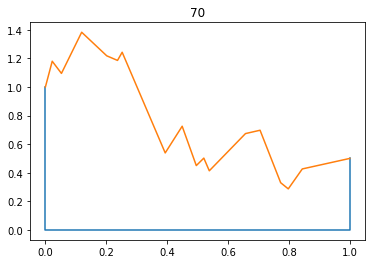

(22, 2)
[[ 4.69000000e+02 -1.20000000e+01  0.00000000e+00]
 [ 5.99000000e+02 -3.40000000e+01  7.82998777e-02]
 [ 5.90000000e+02 -5.20000000e+01  9.46633287e-02]
 [ 5.02000000e+02 -7.80000000e+01  8.72887308e-02]
 [ 4.80000000e+02 -1.03000000e+02  1.06087725e-01]
 [ 5.43000000e+02 -1.29000000e+02  1.61147990e-01]
 [ 5.09000000e+02 -1.46000000e+02  1.66058725e-01]
 [ 5.04000000e+02 -1.78000000e+02  1.99697540e-01]
 [ 6.41000000e+02 -2.21000000e+02  3.04323939e-01]
 [ 3.50000000e+02 -2.87000000e+02  2.57646472e-01]
 [ 4.80000000e+02 -3.57000000e+02  3.89505641e-01]
 [ 4.89000000e+02 -3.83000000e+02  4.22238207e-01]
 [ 2.93000000e+02 -4.31000000e+02  3.94756219e-01]
 [ 4.09000000e+02 -5.03000000e+02  5.23058362e-01]
 [ 6.51000000e+02 -5.77000000e+02  7.05690108e-01]
 [ 6.64000000e+02 -6.07000000e+02  7.44539852e-01]
 [ 5.77000000e+02 -6.33000000e+02  7.37578730e-01]
 [ 5.73000000e+02 -6.62000000e+02  7.68283565e-01]
 [ 6.64000000e+02 -7.05000000e+02  8.53890072e-01]
 [ 6.18000000e+02 -7.23

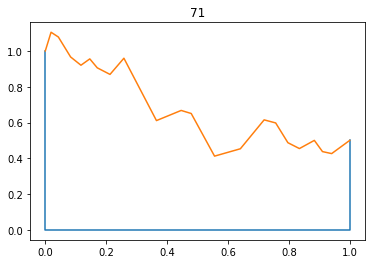

(4, 2)
[[-9.10000000e+01  3.11000000e+02  0.00000000e+00]
 [-3.10000000e+01  4.94000000e+02  1.70351408e-01]
 [ 4.29000000e+02  4.77000000e+02  7.55368439e-01]
 [ 5.80000000e+02  5.75000000e+02  1.00000000e+00]]


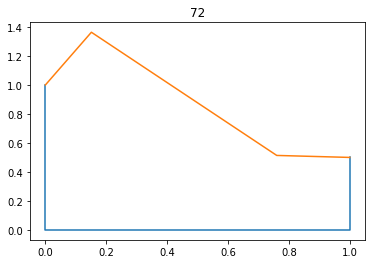

(6, 2)
[[3.90000000e+01 6.19000000e+02 0.00000000e+00]
 [1.54000000e+02 5.34000000e+02 1.21314694e-01]
 [4.22000000e+02 5.70000000e+02 4.90099235e-01]
 [4.70000000e+02 5.34000000e+02 5.40543102e-01]
 [5.41000000e+02 4.33000000e+02 5.97601377e-01]
 [7.39000000e+02 8.13000000e+02 1.00000000e+00]]


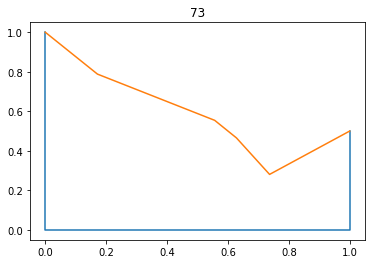

(19, 2)
[[-1.42000000e+02  2.40000000e+02  0.00000000e+00]
 [-9.90000000e+01  3.57000000e+02  1.55415420e-01]
 [-1.11000000e+02  4.17000000e+02  1.98939610e-01]
 [-9.70000000e+01  4.22000000e+02  2.18502601e-01]
 [-1.00000000e+00  3.47000000e+02  2.50151628e-01]
 [ 1.60000000e+01  3.88000000e+02  3.06665596e-01]
 [ 8.00000000e+00  5.36000000e+02  4.36973069e-01]
 [ 3.30000000e+01  5.21000000e+02  4.49464784e-01]
 [ 3.00000000e+01  5.52000000e+02  4.75351957e-01]
 [ 1.10000000e+02  4.97000000e+02  5.08760268e-01]
 [ 8.90000000e+01  5.90000000e+02  5.73673006e-01]
 [ 3.19000000e+02  4.61000000e+02  6.97037736e-01]
 [ 3.12000000e+02  4.93000000e+02  7.19613199e-01]
 [ 3.34000000e+02  5.06000000e+02  7.55178439e-01]
 [ 4.15000000e+02  5.05000000e+02  8.40294821e-01]
 [ 4.23000000e+02  5.16000000e+02  8.59110718e-01]
 [ 3.76000000e+02  6.54000000e+02  9.38605828e-01]
 [ 4.16000000e+02  6.46000000e+02  9.73598699e-01]
 [ 3.87000000e+02  7.07000000e+02  1.00000000e+00]]


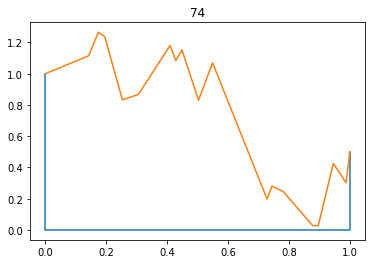

(18, 2)
[[-1.68000000e+02  4.93000000e+02  0.00000000e+00]
 [-7.40000000e+01  3.74000000e+02  8.38520486e-02]
 [-6.70000000e+01  4.20000000e+02  1.14380170e-01]
 [-7.00000000e+00  4.96000000e+02  2.35164744e-01]
 [ 2.90000000e+01  4.84000000e+02  2.82139597e-01]
 [ 8.00000000e+01  5.06000000e+02  3.65950148e-01]
 [ 9.20000000e+01  6.15000000e+02  4.31626414e-01]
 [ 1.47000000e+02  5.57000000e+02  4.85835616e-01]
 [ 1.58000000e+02  5.79000000e+02  5.11550059e-01]
 [ 2.29000000e+02  4.69000000e+02  5.65980579e-01]
 [ 2.38000000e+02  5.14000000e+02  5.98970869e-01]
 [ 2.63000000e+02  5.36000000e+02  6.45018950e-01]
 [ 2.72000000e+02  5.96000000e+02  6.84648795e-01]
 [ 3.20000000e+02  5.24000000e+02  7.22494260e-01]
 [ 3.98000000e+02  4.90000000e+02  8.20732011e-01]
 [ 4.06000000e+02  5.14000000e+02  8.42974521e-01]
 [ 4.99000000e+02  4.59000000e+02  9.53702935e-01]
 [ 4.62000000e+02  6.85000000e+02  1.00000000e+00]]


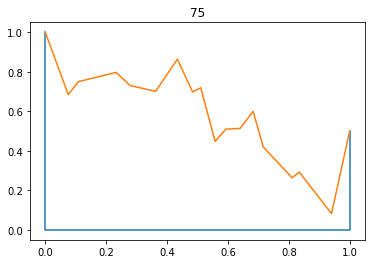

(8, 2)
[[ 2.10000000e+01 -5.62000000e+02  0.00000000e+00]
 [-5.80000000e+01 -3.47000000e+02  7.63517558e-02]
 [-1.56000000e+02 -3.86000000e+02  2.19376236e-01]
 [-3.03000000e+02 -6.09000000e+02  4.59908069e-01]
 [-4.02000000e+02 -6.43000000e+02  6.03538970e-01]
 [-4.76000000e+02 -3.90000000e+02  6.66903046e-01]
 [-4.87000000e+02 -4.34000000e+02  6.89218152e-01]
 [-6.86000000e+02 -6.42000000e+02  1.00000000e+00]]


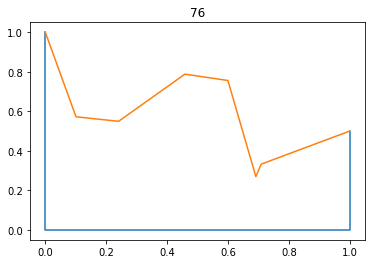

(14, 2)
[[ 3.16000000e+02 -1.95000000e+02  0.00000000e+00]
 [ 3.09000000e+02 -2.23000000e+02  2.73829915e-02]
 [ 2.06000000e+02 -2.57000000e+02  1.44655612e-01]
 [ 6.00000000e+01 -2.52000000e+02  2.70688721e-01]
 [ 1.07000000e+02 -3.66000000e+02  3.15048051e-01]
 [ 2.70000000e+01 -3.53000000e+02  3.76353764e-01]
 [ 4.50000000e+01 -4.61000000e+02  4.41963471e-01]
 [ 8.00000000e+01 -5.05000000e+02  4.44094364e-01]
 [-2.50000000e+01 -4.80000000e+02  5.18559871e-01]
 [-6.80000000e+01 -5.03000000e+02  5.74172764e-01]
 [-8.50000000e+01 -7.32000000e+02  7.62339434e-01]
 [-1.33000000e+02 -7.63000000e+02  8.28443400e-01]
 [-2.90000000e+02 -7.37000000e+02  9.48387466e-01]
 [-3.37000000e+02 -7.50000000e+02  1.00000000e+00]]


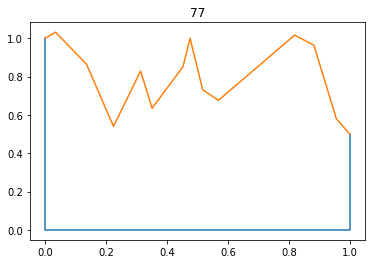

(17, 2)
[[-5.23000000e+02 -1.88000000e+02  0.00000000e+00]
 [-5.07000000e+02 -1.40000000e+02  6.41869106e-02]
 [-3.63000000e+02  5.00000000e+00  2.73455452e-01]
 [-4.57000000e+02  1.03000000e+02  3.84152434e-01]
 [-4.69000000e+02  1.42000000e+02  4.32287596e-01]
 [-3.59000000e+02  2.26000000e+02  5.57789475e-01]
 [-3.83000000e+02  2.31000000e+02  5.60351796e-01]
 [-3.16000000e+02  2.81000000e+02  6.35300123e-01]
 [-4.03000000e+02  3.10000000e+02  6.58548464e-01]
 [-5.70000000e+02  3.14000000e+02  6.36851574e-01]
 [-5.86000000e+02  3.27000000e+02  6.50968611e-01]
 [-5.80000000e+02  3.44000000e+02  6.73755031e-01]
 [-4.23000000e+02  4.70000000e+02  8.60722504e-01]
 [-4.36000000e+02  4.75000000e+02  8.65052175e-01]
 [-4.16000000e+02  5.27000000e+02  9.35016443e-01]
 [-3.68000000e+02  5.59000000e+02  9.83805993e-01]
 [-4.27000000e+02  5.79000000e+02  1.00000000e+00]]


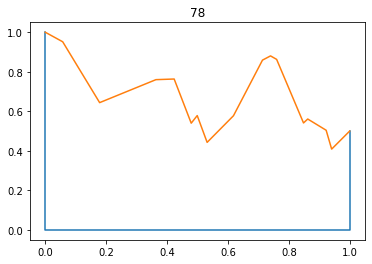

(16, 2)
[[-2.98000000e+02  1.33000000e+02  0.00000000e+00]
 [-3.20000000e+02  1.82000000e+02  6.68014289e-02]
 [-3.80000000e+02  2.38000000e+02  1.44596781e-01]
 [-1.94000000e+02  2.35000000e+02  1.32821068e-01]
 [-2.97000000e+02  3.24000000e+02  2.56778229e-01]
 [-2.29000000e+02  3.21000000e+02  2.49914039e-01]
 [-2.14000000e+02  3.50000000e+02  2.88283283e-01]
 [-2.39000000e+02  4.65000000e+02  4.43953614e-01]
 [-3.80000000e+02  5.88000000e+02  6.15209075e-01]
 [-3.93000000e+02  6.19000000e+02  6.57432978e-01]
 [-3.57000000e+02  6.41000000e+02  6.85515891e-01]
 [-1.75000000e+02  6.20000000e+02  6.49703752e-01]
 [-1.49000000e+02  6.50000000e+02  6.88959749e-01]
 [-2.23000000e+02  7.40000000e+02  8.13054447e-01]
 [-1.08000000e+02  7.36000000e+02  8.02889366e-01]
 [-3.21000000e+02  8.76000000e+02  1.00000000e+00]]


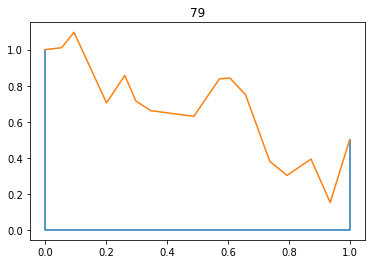

(16, 2)
[[-5.70000000e+01  2.52000000e+02  0.00000000e+00]
 [-2.90000000e+01  4.89000000e+02  2.35427013e-01]
 [-8.00000000e+00  4.84000000e+02  2.51109756e-01]
 [ 8.00000000e+00  5.67000000e+02  3.39482965e-01]
 [ 1.90000000e+01  5.76000000e+02  3.57926789e-01]
 [ 7.90000000e+01  4.99000000e+02  3.47522884e-01]
 [ 1.46000000e+02  4.62000000e+02  3.79028620e-01]
 [ 1.55000000e+02  5.43000000e+02  4.58946226e-01]
 [ 2.09000000e+02  4.81000000e+02  4.56009409e-01]
 [ 2.34000000e+02  5.81000000e+02  5.67956580e-01]
 [ 2.60000000e+02  6.05000000e+02  6.13952082e-01]
 [ 4.37000000e+02  4.12000000e+02  6.13325177e-01]
 [ 4.44000000e+02  5.49000000e+02  7.40630655e-01]
 [ 4.77000000e+02  5.61000000e+02  7.82756587e-01]
 [ 4.97000000e+02  5.50000000e+02  7.92200704e-01]
 [ 5.09000000e+02  7.73000000e+02  1.00000000e+00]]


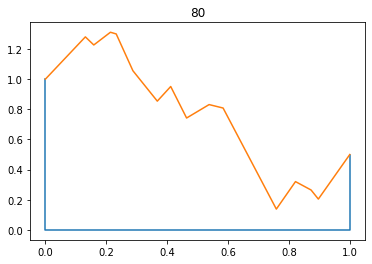

(5, 2)
[[-1.80000000e+01 -6.08000000e+02  0.00000000e+00]
 [-1.01000000e+02 -5.18000000e+02  1.17497493e-01]
 [-4.00000000e+02 -3.49000000e+02  5.36307139e-01]
 [-5.64000000e+02 -3.77000000e+02  7.62550598e-01]
 [-7.40000000e+02 -5.93000000e+02  1.00000000e+00]]


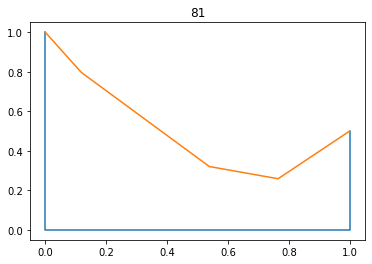

(2, 2)
[[ 578.  -52.    0.]
 [ 201. -712.    1.]]


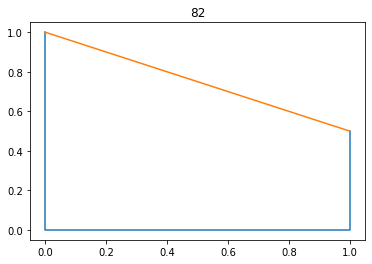

(21, 2)
[[ 3.48000000e+02 -2.90000000e+01  0.00000000e+00]
 [ 4.69000000e+02 -7.40000000e+01  1.29438986e-01]
 [ 4.87000000e+02 -9.30000000e+01  1.63308475e-01]
 [ 4.52000000e+02 -1.08000000e+02  1.59139311e-01]
 [ 5.31000000e+02 -1.42000000e+02  2.49135485e-01]
 [ 5.37000000e+02 -1.59000000e+02  2.73092833e-01]
 [ 4.67000000e+02 -1.83000000e+02  2.57629027e-01]
 [ 4.79000000e+02 -2.13000000e+02  3.00793404e-01]
 [ 6.93000000e+02 -2.71000000e+02  5.04082531e-01]
 [ 7.85000000e+02 -3.21000000e+02  6.21245046e-01]
 [ 6.43000000e+02 -3.64000000e+02  5.83123371e-01]
 [ 6.57000000e+02 -3.91000000e+02  6.23981172e-01]
 [ 7.65000000e+02 -4.39000000e+02  7.48817835e-01]
 [ 5.35000000e+02 -5.13000000e+02  6.92239942e-01]
 [ 6.69000000e+02 -5.46000000e+02  8.15593032e-01]
 [ 6.65000000e+02 -5.70000000e+02  8.41582622e-01]
 [ 6.37000000e+02 -5.87000000e+02  8.44185190e-01]
 [ 6.96000000e+02 -6.11000000e+02  9.09743930e-01]
 [ 6.11000000e+02 -6.59000000e+02  9.13360815e-01]
 [ 6.03000000e+02 -6.81

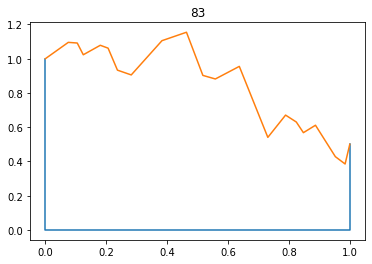

(14, 2)
[[ 2.70000000e+01 -3.34000000e+02  0.00000000e+00]
 [ 1.30000000e+01 -6.33000000e+02  2.33699013e-01]
 [-4.70000000e+01 -6.02000000e+02  2.82151698e-01]
 [-2.05000000e+02 -3.24000000e+02  2.67137973e-01]
 [-2.85000000e+02 -5.18000000e+02  5.02645798e-01]
 [-3.23000000e+02 -5.44000000e+02  5.66472430e-01]
 [-3.53000000e+02 -4.74000000e+02  5.51119673e-01]
 [-3.74000000e+02 -4.90000000e+02  5.87577173e-01]
 [-3.89000000e+02 -6.22000000e+02  7.01179870e-01]
 [-4.44000000e+02 -5.85000000e+02  7.39361425e-01]
 [-4.57000000e+02 -7.01000000e+02  8.38979051e-01]
 [-4.80000000e+02 -7.06000000e+02  8.69813629e-01]
 [-5.63000000e+02 -5.51000000e+02  8.55418252e-01]
 [-5.87000000e+02 -7.11000000e+02  1.00000000e+00]]


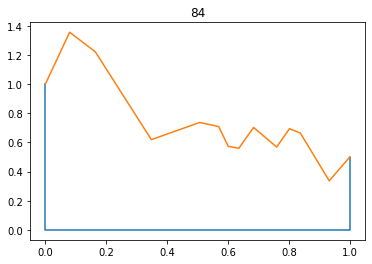

(2, 2)
[[ 618. -611.    0.]
 [ 385. -749.    1.]]


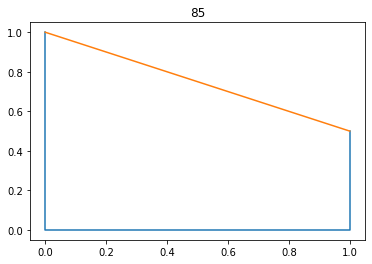

(6, 2)
[[1.90000000e+01 3.10000000e+02 0.00000000e+00]
 [2.63000000e+02 6.76000000e+02 3.01434968e-01]
 [3.42000000e+02 5.52000000e+02 3.91169469e-01]
 [4.01000000e+02 4.98000000e+02 4.59437937e-01]
 [7.19000000e+02 4.62000000e+02 8.35661522e-01]
 [8.61000000e+02 3.33000000e+02 1.00000000e+00]]


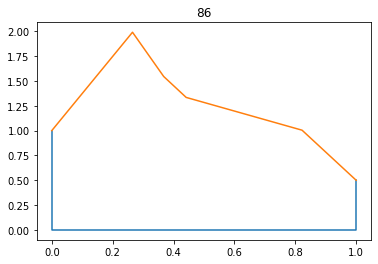

(14, 2)
[[ 5.32000000e+02 -1.68000000e+02  0.00000000e+00]
 [ 4.30000000e+02 -1.68000000e+02  2.39535333e-03]
 [ 4.50000000e+02 -1.98000000e+02  5.03806994e-02]
 [ 3.85000000e+02 -2.08000000e+02  6.80588245e-02]
 [ 3.94000000e+02 -2.32000000e+02  1.06611488e-01]
 [ 3.24000000e+02 -2.36000000e+02  1.14716028e-01]
 [ 5.59000000e+02 -3.90000000e+02  3.57933108e-01]
 [ 5.09000000e+02 -3.98000000e+02  3.72028640e-01]
 [ 5.47000000e+02 -5.20000000e+02  5.68186681e-01]
 [ 2.75000000e+02 -5.34000000e+02  5.97186634e-01]
 [ 3.73000000e+02 -6.05000000e+02  7.09562104e-01]
 [ 3.74000000e+02 -6.22000000e+02  7.36996467e-01]
 [ 2.10000000e+02 -6.66000000e+02  8.11915187e-01]
 [ 5.23000000e+02 -7.87000000e+02  1.00000000e+00]]


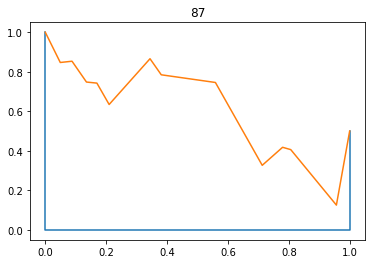

(23, 2)
[[ 1.63000000e+02  7.60000000e+01  0.00000000e+00]
 [ 2.83000000e+02  5.60000000e+01  1.09752547e-01]
 [ 3.74000000e+02  6.80000000e+01  1.72023290e-01]
 [ 3.58000000e+02  3.10000000e+01  1.87991266e-01]
 [ 2.85000000e+02 -3.90000000e+01  1.84614265e-01]
 [ 3.37000000e+02 -1.08000000e+02  2.78719068e-01]
 [ 4.91000000e+02 -1.30000000e+02  4.16739447e-01]
 [ 5.25000000e+02 -1.52000000e+02  4.60436681e-01]
 [ 4.55000000e+02 -2.37000000e+02  4.70989811e-01]
 [ 6.12000000e+02 -2.32000000e+02  5.90538574e-01]
 [ 5.71000000e+02 -2.68000000e+02  5.86084425e-01]
 [ 6.14000000e+02 -2.79000000e+02  6.28369723e-01]
 [ 4.97000000e+02 -3.76000000e+02  6.11237263e-01]
 [ 5.09000000e+02 -4.04000000e+02  6.42270742e-01]
 [ 5.61000000e+02 -4.54000000e+02  7.21717613e-01]
 [ 6.16000000e+02 -4.53000000e+02  7.64177584e-01]
 [ 5.97000000e+02 -4.81000000e+02  7.70844250e-01]
 [ 6.07000000e+02 -4.92000000e+02  7.87190684e-01]
 [ 7.08000000e+02 -4.92000000e+02  8.66579330e-01]
 [ 6.94000000e+02 -5.24

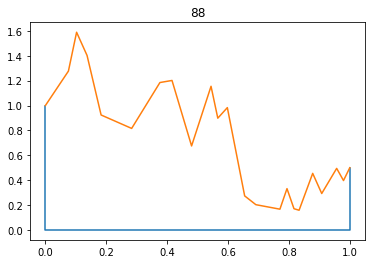

(17, 2)
[[-3.86000000e+02 -1.85000000e+02  0.00000000e+00]
 [-4.39000000e+02 -1.87000000e+02 -1.77613715e-03]
 [-4.04000000e+02 -1.49000000e+02  5.18599307e-02]
 [-4.05000000e+02 -1.05000000e+02  1.14814580e-01]
 [-3.22000000e+02 -3.00000000e+01  2.20390382e-01]
 [-2.83000000e+02  2.90000000e+01  3.03981371e-01]
 [-2.97000000e+02  4.00000000e+01  3.20001391e-01]
 [-4.46000000e+02  2.30000000e+01  2.98734809e-01]
 [-5.38000000e+02  3.40000000e+01  3.16350898e-01]
 [-4.74000000e+02  9.00000000e+01  3.95139359e-01]
 [-5.01000000e+02  9.90000000e+01  4.08564746e-01]
 [-4.07000000e+02  1.78000000e+02  5.19636751e-01]
 [-4.26000000e+02  2.14000000e+02  5.71517144e-01]
 [-5.39000000e+02  3.03000000e+02  7.01128093e-01]
 [-5.40000000e+02  3.21000000e+02  7.26894359e-01]
 [-4.11000000e+02  4.56000000e+02  9.17348235e-01]
 [-3.96000000e+02  5.14000000e+02  1.00000000e+00]]


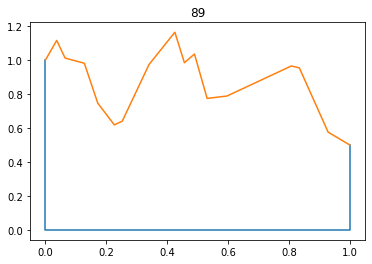

(13, 2)
[[-7.90000000e+01  1.94000000e+02  0.00000000e+00]
 [-1.82000000e+02  5.28000000e+02  9.96047752e-02]
 [-6.50000000e+01  4.38000000e+02  2.03464985e-01]
 [-5.50000000e+01  5.31000000e+02  2.87845483e-01]
 [ 1.19000000e+02  3.38000000e+02  3.97948079e-01]
 [ 2.02000000e+02  4.09000000e+02  5.72740316e-01]
 [ 2.52000000e+02  3.68000000e+02  6.15221570e-01]
 [ 2.31000000e+02  6.15000000e+02  7.69678677e-01]
 [ 2.86000000e+02  5.60000000e+02  8.08984597e-01]
 [ 2.95000000e+02  5.83000000e+02  8.39411494e-01]
 [ 3.64000000e+02  5.34000000e+02  9.03719445e-01]
 [ 3.74000000e+02  5.61000000e+02  9.38610216e-01]
 [ 4.62000000e+02  4.71000000e+02  1.00000000e+00]]


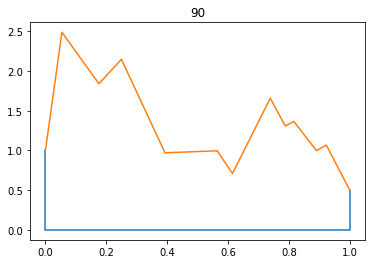

(15, 2)
[[-1.15000000e+02  1.45000000e+02  0.00000000e+00]
 [-1.29000000e+02  2.95000000e+02  1.68592216e-01]
 [-8.00000000e+01  2.85000000e+02  1.94174366e-01]
 [-3.60000000e+01  3.03000000e+02  2.49398749e-01]
 [-3.00000000e+01  3.44000000e+02  3.03008372e-01]
 [-5.90000000e+01  4.10000000e+02  3.59692288e-01]
 [-3.10000000e+01  4.27000000e+02  4.01464371e-01]
 [ 9.50000000e+01  3.86000000e+02  4.48973791e-01]
 [ 4.50000000e+01  6.01000000e+02  6.67692103e-01]
 [ 6.00000000e+01  6.52000000e+02  7.40150671e-01]
 [ 8.00000000e+01  6.61000000e+02  7.66230755e-01]
 [ 2.41000000e+02  6.11000000e+02  8.29793024e-01]
 [ 2.70000000e+02  6.36000000e+02  8.81894732e-01]
 [ 2.37000000e+02  7.27000000e+02  9.65400596e-01]
 [ 2.65000000e+02  7.38000000e+02  1.00000000e+00]]


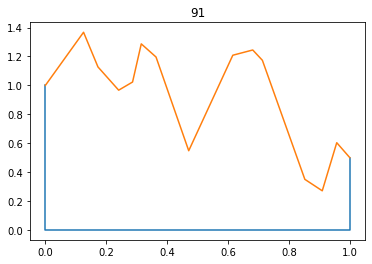

(20, 2)
[[-3.08000000e+02  3.20000000e+01  0.00000000e+00]
 [-3.89000000e+02  1.12000000e+02  1.06298513e-01]
 [-5.27000000e+02  1.72000000e+02  2.00365464e-01]
 [-5.98000000e+02  2.38000000e+02  2.88836913e-01]
 [-5.56000000e+02  3.00000000e+02  3.51764607e-01]
 [-4.41000000e+02  3.43000000e+02  3.79464280e-01]
 [-3.83000000e+02  4.07000000e+02  4.41702721e-01]
 [-3.87000000e+02  4.27000000e+02  4.65260200e-01]
 [-6.50000000e+02  5.53000000e+02  6.57824820e-01]
 [-6.11000000e+02  5.75000000e+02  6.75679936e-01]
 [-4.16000000e+02  6.02000000e+02  6.70274111e-01]
 [-4.00000000e+02  6.19000000e+02  6.86695955e-01]
 [-4.36000000e+02  6.70000000e+02  7.51557831e-01]
 [-5.10000000e+02  6.94000000e+02  7.92675222e-01]
 [-5.23000000e+02  7.62000000e+02  8.72659246e-01]
 [-4.22000000e+02  7.86000000e+02  8.81284254e-01]
 [-4.08000000e+02  8.02000000e+02  8.96936700e-01]
 [-5.69000000e+02  8.61000000e+02  9.94133338e-01]
 [-5.69000000e+02  8.72000000e+02  1.00668148e+00]
 [-4.47000000e+02  8.86

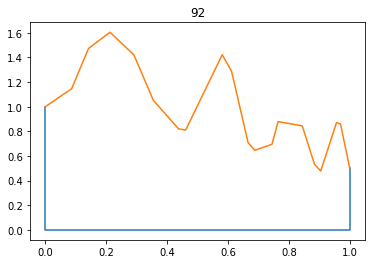

(3, 2)
[[-134.          405.            0.        ]
 [ 330.          401.            0.68492222]
 [ 404.          676.            1.        ]]


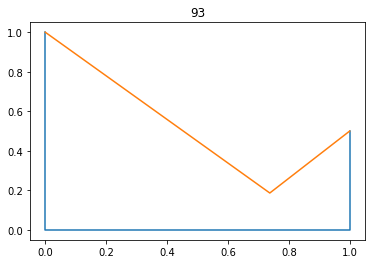

(9, 2)
[[ 1.59000000e+02  1.09000000e+02  0.00000000e+00]
 [ 4.17000000e+02  7.90000000e+01  2.43078435e-01]
 [ 4.93000000e+02 -3.10000000e+01  4.22907665e-01]
 [ 4.76000000e+02 -1.33000000e+02  5.18125987e-01]
 [ 3.92000000e+02 -2.58000000e+02  5.83159414e-01]
 [ 4.01000000e+02 -3.31000000e+02  6.68615288e-01]
 [ 5.08000000e+02 -3.52000000e+02  7.78582450e-01]
 [ 5.72000000e+02 -3.91000000e+02  8.72642117e-01]
 [ 6.10000000e+02 -4.81000000e+02  1.00000000e+00]]


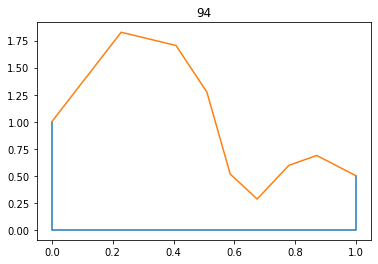

(14, 2)
[[1.70000000e+01 2.83000000e+02 0.00000000e+00]
 [1.57000000e+02 2.87000000e+02 2.27147676e-01]
 [1.92000000e+02 3.62000000e+02 2.70640160e-01]
 [2.76000000e+02 4.49000000e+02 3.91729993e-01]
 [3.10000000e+02 4.62000000e+02 4.44733441e-01]
 [3.25000000e+02 4.30000000e+02 4.74896632e-01]
 [3.79000000e+02 5.32000000e+02 5.44463155e-01]
 [4.95000000e+02 5.36000000e+02 7.32548037e-01]
 [5.45000000e+02 5.93000000e+02 8.03688549e-01]
 [5.66000000e+02 3.82000000e+02 8.75775598e-01]
 [5.91000000e+02 3.99000000e+02 9.13411881e-01]
 [6.28000000e+02 4.68000000e+02 9.61237525e-01]
 [6.40000000e+02 4.39000000e+02 9.85978903e-01]
 [6.24000000e+02 2.16000000e+02 1.00000000e+00]]


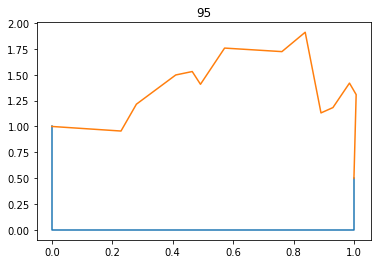

(18, 2)
[[ 9.90000000e+01 -3.04000000e+02  0.00000000e+00]
 [ 1.64000000e+02 -5.63000000e+02  2.90560889e-02]
 [ 6.10000000e+01 -5.14000000e+02  1.48646879e-01]
 [ 5.40000000e+01 -5.34000000e+02  1.67466388e-01]
 [-3.10000000e+01 -5.05000000e+02  2.71399246e-01]
 [-8.20000000e+01 -4.39000000e+02  3.11486004e-01]
 [-9.50000000e+01 -4.99000000e+02  3.56911750e-01]
 [-1.20000000e+02 -5.14000000e+02  3.98263562e-01]
 [-1.31000000e+02 -5.50000000e+02  4.29932122e-01]
 [-2.07000000e+02 -4.53000000e+02  4.90289294e-01]
 [-2.15000000e+02 -4.73000000e+02  5.10487901e-01]
 [-2.69000000e+02 -4.28000000e+02  5.64336069e-01]
 [-2.90000000e+02 -5.20000000e+02  6.35459917e-01]
 [-3.56000000e+02 -5.39000000e+02  7.35187899e-01]
 [-3.81000000e+02 -5.27000000e+02  7.64165847e-01]
 [-4.55000000e+02 -5.96000000e+02  8.97841174e-01]
 [-4.70000000e+02 -6.32000000e+02  9.35026125e-01]
 [-5.54000000e+02 -5.21000000e+02  1.00000000e+00]]


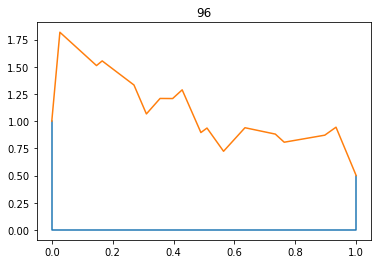

(24, 2)
[[-4.60000000e+01 -2.15000000e+02  0.00000000e+00]
 [-1.03000000e+02 -3.78000000e+02  7.16246835e-02]
 [-1.58000000e+02 -4.58000000e+02  1.42796215e-01]
 [-1.71000000e+02 -4.41000000e+02  1.60575770e-01]
 [-1.75000000e+02 -2.65000000e+02  1.70598427e-01]
 [-1.91000000e+02 -2.77000000e+02  1.91603359e-01]
 [-1.96000000e+02 -2.42000000e+02  1.99200320e-01]
 [-2.34000000e+02 -2.59000000e+02  2.49393576e-01]
 [-2.47000000e+02 -2.51000000e+02  2.66933227e-01]
 [-3.65000000e+02 -4.52000000e+02  4.18845795e-01]
 [-3.84000000e+02 -4.23000000e+02  4.44942023e-01]
 [-3.94000000e+02 -3.51000000e+02  4.60189258e-01]
 [-4.19000000e+02 -3.38000000e+02  4.93855791e-01]
 [-4.58000000e+02 -3.93000000e+02  5.44368919e-01]
 [-4.98000000e+02 -2.97000000e+02  6.00239904e-01]
 [-5.30000000e+02 -3.38000000e+02  6.41796615e-01]
 [-5.38000000e+02 -2.72000000e+02  6.54218313e-01]
 [-5.87000000e+02 -3.19000000e+02  7.18272691e-01]
 [-5.88000000e+02 -2.70000000e+02  7.20911635e-01]
 [-6.40000000e+02 -2.65

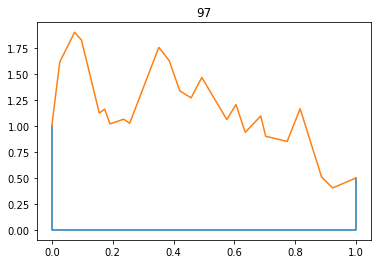

(16, 2)
[[-2.02000000e+02 -1.51000000e+02  0.00000000e+00]
 [-2.48000000e+02 -1.33000000e+02  6.36826254e-02]
 [-4.08000000e+02 -1.39000000e+02  2.11797694e-01]
 [-3.94000000e+02 -9.20000000e+01  2.48551251e-01]
 [-3.15000000e+02  2.50000000e+01  2.97403676e-01]
 [-3.60000000e+02  2.30000000e+01  3.38726763e-01]
 [-3.95000000e+02  4.30000000e+01  3.93924603e-01]
 [-3.50000000e+02  1.23000000e+02  4.36036972e-01]
 [-3.55000000e+02  1.43000000e+02  4.62259840e-01]
 [-4.11000000e+02  1.54000000e+02  5.28112992e-01]
 [-4.92000000e+02  2.17000000e+02  6.73735590e-01]
 [-5.26000000e+02  2.09000000e+02  6.98016409e-01]
 [-5.32000000e+02  2.60000000e+02  7.58365355e-01]
 [-5.82000000e+02  2.92000000e+02  8.40886904e-01]
 [-5.70000000e+02  3.99000000e+02  9.43753245e-01]
 [-6.67000000e+02  3.64000000e+02  1.00000000e+00]]


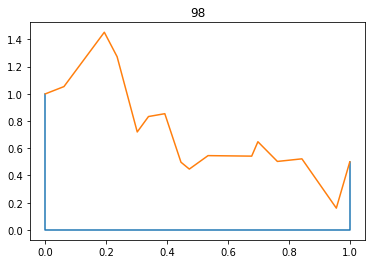

(16, 2)
[[-3.55000000e+02 -3.61000000e+02  0.00000000e+00]
 [-2.91000000e+02 -2.28000000e+02  9.10517111e-02]
 [-3.07000000e+02 -2.17000000e+02  1.21538020e-01]
 [-2.80000000e+02 -1.04000000e+02  2.28411078e-01]
 [-3.37000000e+02 -1.35000000e+02  2.52556840e-01]
 [-3.78000000e+02 -8.90000000e+01  3.52113080e-01]
 [-4.46000000e+02 -1.18000000e+02  3.90524420e-01]
 [-4.36000000e+02 -8.90000000e+01  4.14641468e-01]
 [-4.90000000e+02 -4.30000000e+01  5.28212692e-01]
 [-5.13000000e+02  1.90000000e+01  6.27617531e-01]
 [-5.00000000e+02  5.20000000e+01  6.53313843e-01]
 [-5.37000000e+02  1.11000000e+02  7.64201624e-01]
 [-7.33000000e+02  2.80000000e+01  8.75624527e-01]
 [-7.76000000e+02  2.30000000e+01  9.15964917e-01]
 [-7.87000000e+02  3.50000000e+01  9.42264220e-01]
 [-7.68000000e+02  1.00000000e+02  1.00000000e+00]]


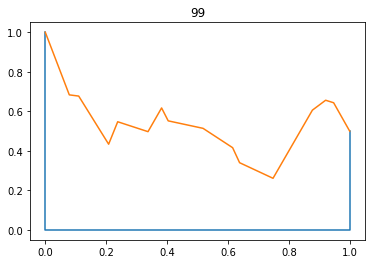

In [30]:
def test(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,canimg = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(canimg, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

    contour = contours[0]
    for c in contours:
        if c.shape[0] > contour.shape[0]:
            contour = c
    contour = cv2.approxPolyDP(contour, 10, True)
    contour = contour.reshape((-1,2))

    base = find_base_points_idx(contour)
    return np.array([contour[_] for _ in base])
    #return np.array(res)
def generate_data2(path):
    images_paths = [os.path.join(path,x) for x in os.listdir(path) if ".png" in x]
    points = []
    for p in sorted(images_paths, key=lambda x: int(x.split("/")[-1].split(".")[0])): #TODO
        print(p)
        image = cv2.imread(p)
        image = cv2.resize(image, (1000,1000))
        points.append(test(image))
    return zip(points,generate_data(path))
                      
bases = generate_data2("set8")
i = 0
for base,top in bases:
    #plt.plot(base[:,0], base[:,1])
    #plt.show()
    #tr@base = [[1,0,0],[0,0,0],[0,1,0]]
    abc = base[1]
    
    top -= abc
    base -= abc
    
    a = np.zeros((3,3))
    a[0,:2] = base[0]
    a[1,:2] = base[2]
    a[2,:2] = base[3]
    a[1,2] = 0.5
    a[2,2] = 1
    
    
    
    tr = np.linalg.inv(a)@np.array([[0,1,0],[1,0,0],[1,0.5,0]])
    a = np.zeros((4,3))
    a[0,:2] = base[0]
    a[1,:2] = base[1]
    a[2,:2] = base[2]
    a[3,:2] = base[3]
    a[2,2] = 0.5
    a[3,2] = 1
    
    b = a@tr
    plt.plot(b[:,0], b[:,1])
    print(top.shape)
    t = np.zeros((top.shape[0],3))
    t[:,:2] = top
    #     t = top@tr
#     plt.plot(t[:,0], t[:,1])
#     plt.show()
    aa = []
    for a in top:
        aa.append(np.dot(a-top[0], top[-1]-top[0])/np.linalg.norm(base[2]-base[1]))
    t[:,-1] = np.array(aa)/aa[-1]
    print(t)
    t = t@tr
    plt.plot(t[:,0], t[:,1])
    plt.title(str(i))
    i += 1
    plt.show()
#     plt.show()
#     plt.plot(top[:,0], top[:,1])
#     plt.show()

#     t = np.zeros((top.shape[0],3))
#     t[:,:2] = top
    
#     aa = []
#     for a in top:
#         aa.append(np.dot(a-top[0], top[-1]-top[0])/np.linalg.norm(base[2]-base[1]))
#     t[:,-1] = (np.array(aa)/aa[-1]*1)
#     t = t@tr
#     plt.plot(t[:,0], t[:,1])
#     plt.show()
        
    